# Exploratory data analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from utils.experiments import get_bh_integral, get_waveform_est
from utils.data import ALL_B_COLS, ALL_H_COLS, load_new_materials, DATA_SOURCE, PROC_SOURCE


plt.style.use("default")
plt.rcParams.update({
    #"text.usetex": False,
    "font.family": "serif",
    #"font.serif": ["Helvetica"],
    'figure.dpi': 200,  # renders images larger for notebook
    'axes.grid': True,
    'grid.alpha': 0.3,

})

IMG_PATH = Path.cwd().parent.parent / 'notebooks' / 'img'
IMG_PATH.mkdir(parents=True, exist_ok=True)

In [2]:
ds = pd.read_pickle(PROC_SOURCE / "ten_materials.pkl.gz")
ds = pd.concat([ds, load_new_materials()], ignore_index=True)
full_b, full_h = ds.loc[:, ALL_B_COLS].to_numpy(), ds.loc[:, ALL_H_COLS].to_numpy()

## Stats

In [3]:
ds.shape

(204524, 2052)

In [4]:
[c for c in ds.columns if not c.startswith(("B_t", "H_t"))]

['freq', 'ploss', 'temp', 'material']

In [5]:
counts_per_mat = ds.loc[:, ["material", 'freq']].groupby("material").agg(["count",]).rename(columns={'freq': ''})
counts_per_mat.columns = ['count']
counts_per_mat = counts_per_mat.sort_values('count', ascending=False).T
counts_per_mat

material   3C90    N87   3C94     77    N27     78   N30   N49     B   3E6  \
count     40712  40615  40067  11443  11395  11379  8977  8601  7399  6995   

material   3F4     C     A     E    D  
count     6563  5356  2431  2012  579

In [9]:
for mat, mat_df in ds.loc[:, ['freq', 'ploss', 'temp', 'material']].groupby('material'):
    print(mat)
    print(mat_df.describe())

3C90
                freq         ploss          temp
count   40712.000000  4.071200e+04  40712.000000
mean   189626.549912  1.609644e+05     58.605816
std    112005.168388  2.731222e+05     24.057466
min     49950.000000  4.061182e+02     25.000000
25%     99900.000000  9.269587e+03     25.000000
50%    158740.000000  4.096863e+04     50.000000
75%    251260.000000  1.841387e+05     70.000000
max    446690.000000  2.796374e+06     90.000000
3C94
                freq         ploss          temp
count   40067.000000  4.006700e+04  40067.000000
mean   201781.394165  2.447935e+05     58.713655
std    115003.408491  4.127824e+05     24.076956
min     49950.000000  6.840462e+02     25.000000
25%     99980.000000  1.641600e+04     25.000000
50%    177930.000000  6.749729e+04     50.000000
75%    282480.000000  2.815700e+05     70.000000
max    446690.000000  3.616133e+06     90.000000
3E6
                freq         ploss         temp
count    6995.000000  6.995000e+03  6995.000000
mean   2

204524 samples


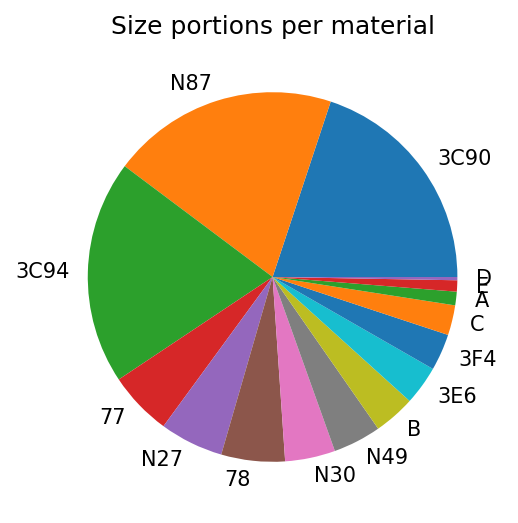

In [10]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.pie(counts_per_mat.to_numpy().ravel(), labels=counts_per_mat.T.index.tolist())
ax.set_title("Size portions per material")
print(len(ds), 'samples')

## Distributions

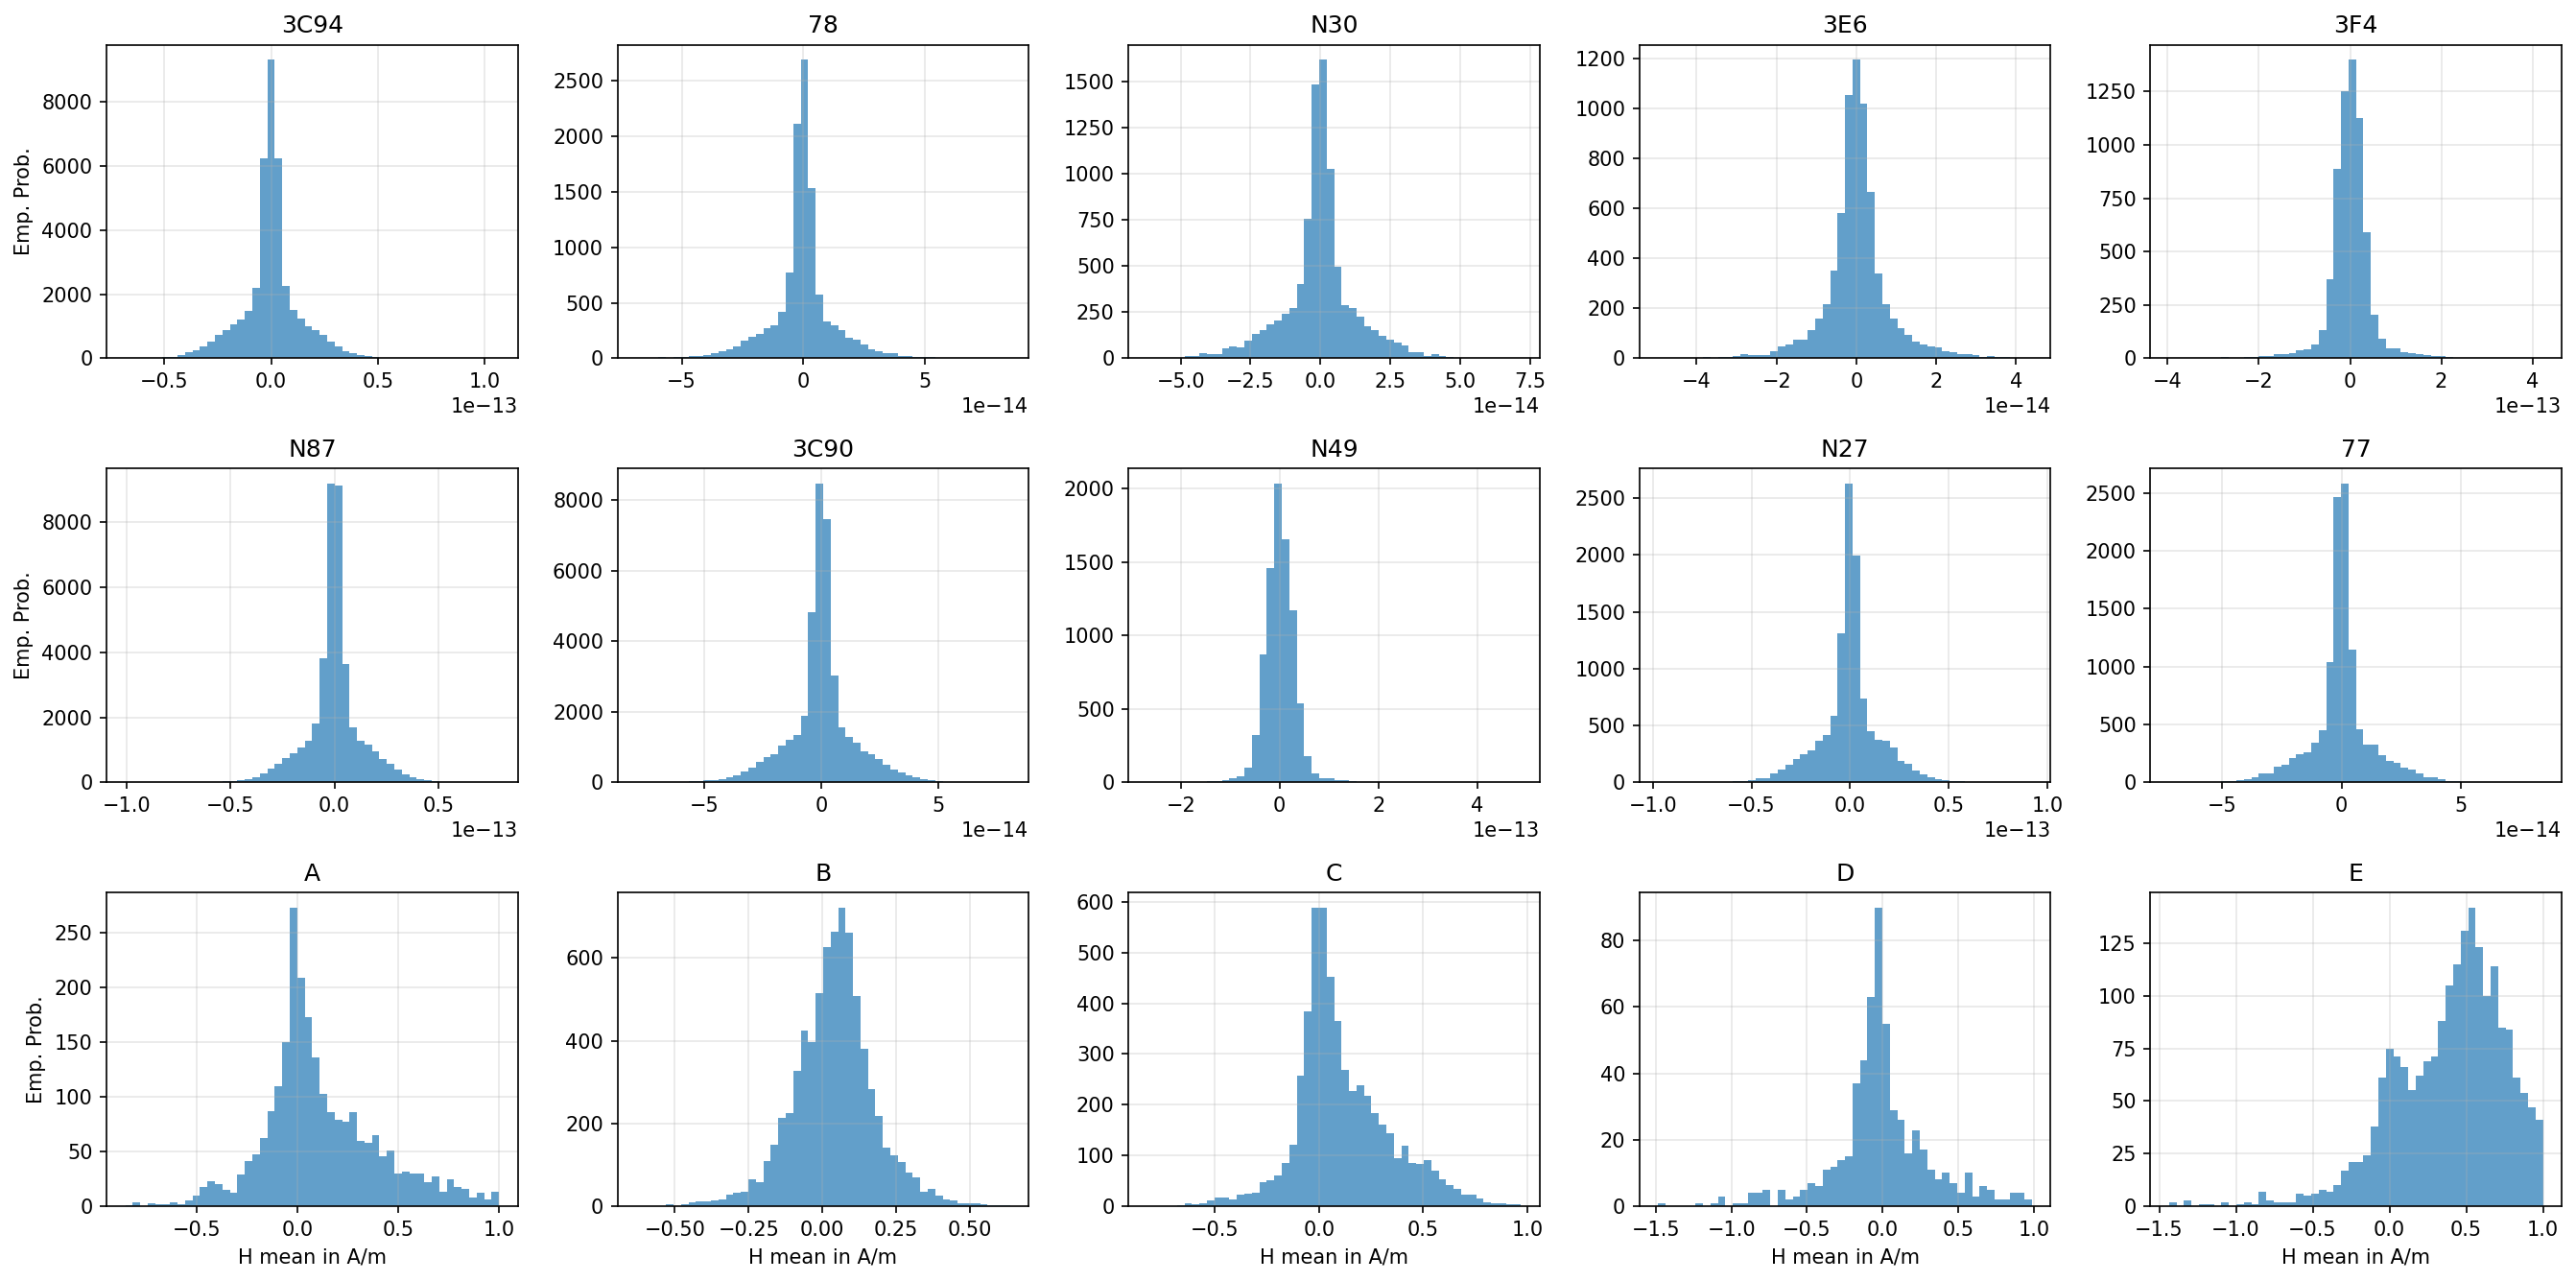

In [6]:
# histogram of H mean values
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=150, sharex=False, sharey=False, figsize=(18, 9))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material", sort=False)):
    ax.hist(mat_df.loc[:, ALL_H_COLS].mean(axis=1), alpha=.7, bins=50)
    ax.set_title(mat_lbl)
for ax in axes[:, 0]:
    ax.set_ylabel("Emp. Prob.")
for ax in axes[-1, :]:
    ax.set_xlabel("H mean in A/m")
fig.tight_layout()

In [17]:
mat_d_bad_h_mean_df = (ds.query("material == 'D'")
            .assign(h_mean=lambda x: x.loc[:, ALL_H_COLS].mean(axis=1))
            .query("h_mean > 0.9")
            .reset_index(drop=True) )
mat_d_bad_h_mean_df

B_t_0     B_t_1     B_t_2     B_t_3     B_t_4     B_t_5     B_t_6  \
0 -0.152566 -0.151739 -0.150921 -0.150111 -0.149309 -0.148516 -0.147727   
1 -0.117102 -0.116203 -0.115317 -0.114447 -0.113590 -0.112740 -0.111889   
2 -0.246047 -0.245129 -0.244231 -0.243349 -0.242472 -0.241598 -0.240739   
3 -0.158517 -0.157989 -0.157513 -0.157063 -0.156613 -0.156167 -0.155752   

      B_t_7     B_t_8     B_t_9  ...   H_t_1016   H_t_1017   H_t_1018  \
0 -0.146934 -0.146133 -0.145327  ... -51.955891 -51.644261 -51.374062   
1 -0.111037 -0.110182 -0.109326  ... -29.191133 -25.315057 -22.622051   
2 -0.239902 -0.239086 -0.238281  ... -90.550862 -90.510092 -89.554461   
3 -0.155386 -0.155061 -0.154748  ... -62.493909 -62.457892 -59.976982   

    H_t_1019   H_t_1020   H_t_1021   H_t_1022   H_t_1023  material    h_mean  
0 -50.866647 -49.676826 -48.326751 -47.598077 -47.712696         D  0.927292  
1 -21.452803 -21.598308 -22.820837 -24.786622 -27.012290         D  0.941363  
2 -86.850689 -82.596017 -78.928992 -77.854731 -79.112229         D  0.931532  
3 -53.487712 -45.189917 -40.151081 -40.955375 -45.704441         D  0.987115  

[4 rows x 2053 columns]

Text(0, 0.5, 'Signal')

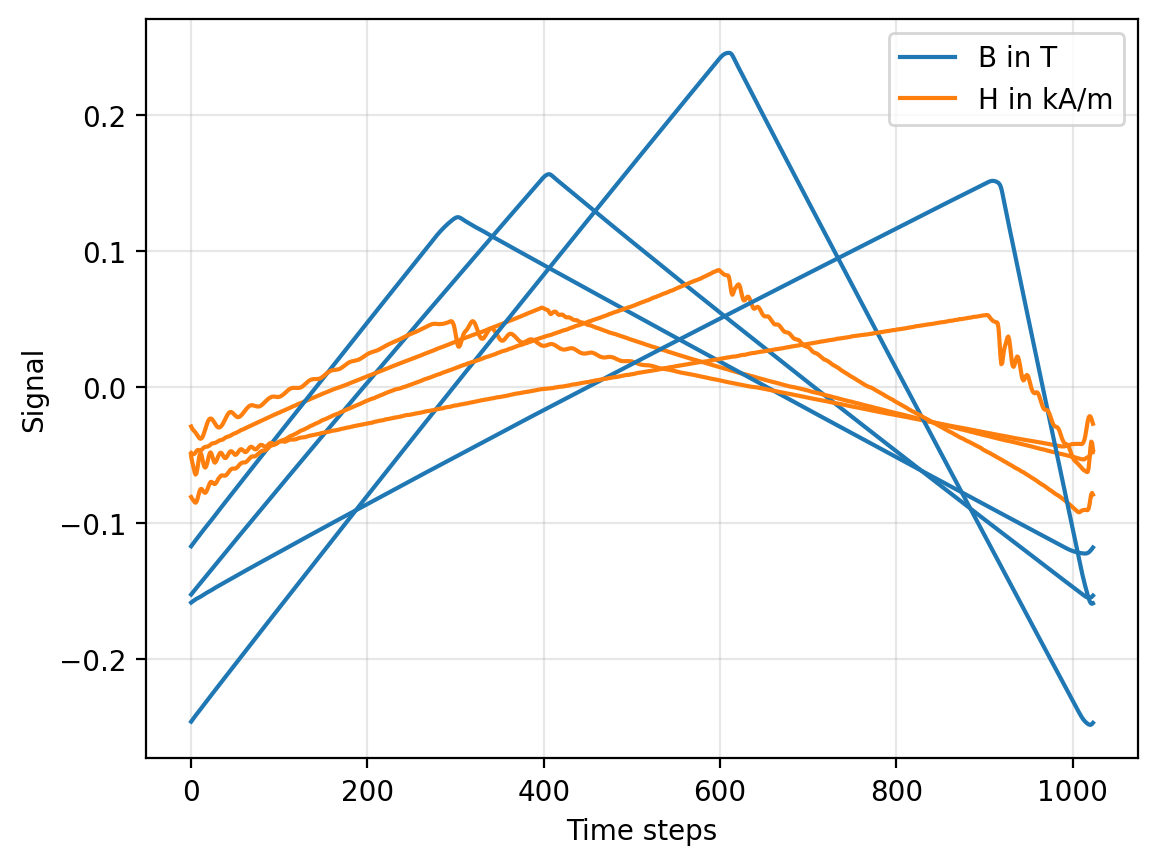

In [22]:
# have a look at four very badly biased B-H Sequences in material D
for i in range(len(mat_d_bad_h_mean_df)):
    plt.plot(np.arange(1024), mat_d_bad_h_mean_df.loc[:, ALL_B_COLS].to_numpy()[i], color='tab:blue', label='B in T' if i == 0 else None)
    plt.plot(np.arange(1024), mat_d_bad_h_mean_df.loc[:, ALL_H_COLS].to_numpy()[i] * 1e-3, color='tab:orange', label='H in kA/m' if i == 0 else None)
plt.legend()
plt.xlabel('Time steps')
plt.ylabel('Signal')

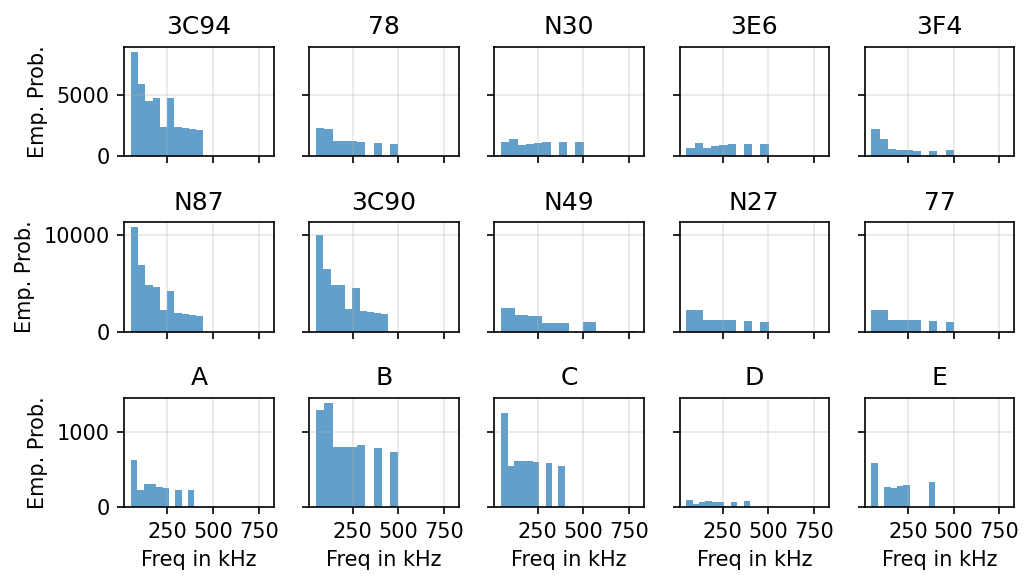

In [11]:
# Histogram of Frequency
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=150, sharex=True, sharey="row", figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material", sort=False)):
    ax.hist(mat_df.freq*1e-3, alpha=.7)
    ax.set_title(mat_lbl)
for ax in axes[:, 0]:
    ax.set_ylabel("Emp. Prob.")
for ax in axes[-1, :]:
    ax.set_xlabel("Freq in kHz")
fig.tight_layout()

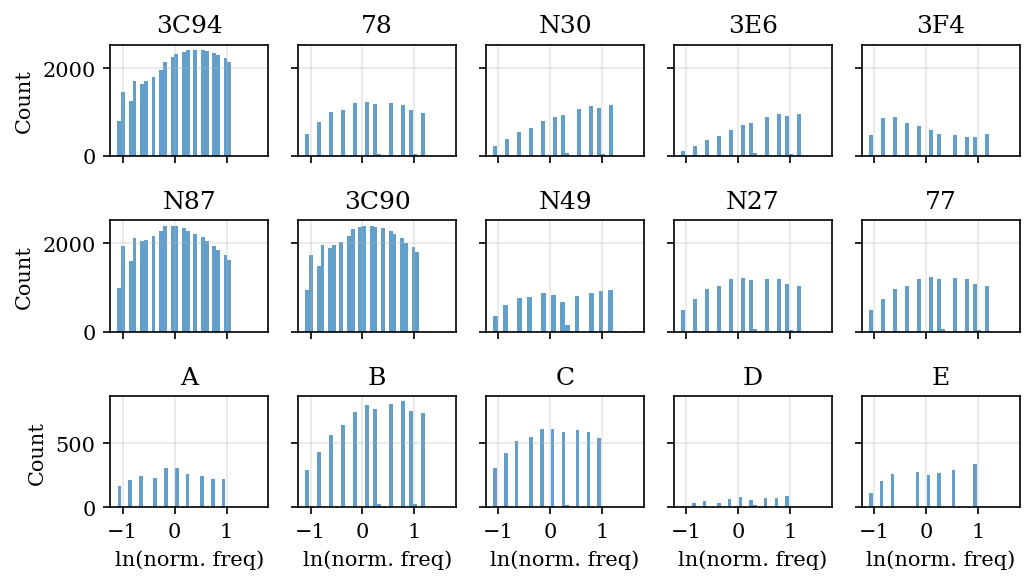

In [6]:
# Histogram of log of normalized frequency
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=150, sharex=True, sharey="row", figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material", sort=False)):
    ax.hist(np.log(mat_df.freq / 150_000), alpha=.7, bins=30)
    ax.set_title(mat_lbl)
for ax in axes[:, 0]:
    ax.set_ylabel("Count")
for ax in axes[-1, :]:
    ax.set_xlabel("ln(norm. freq)")
fig.tight_layout()

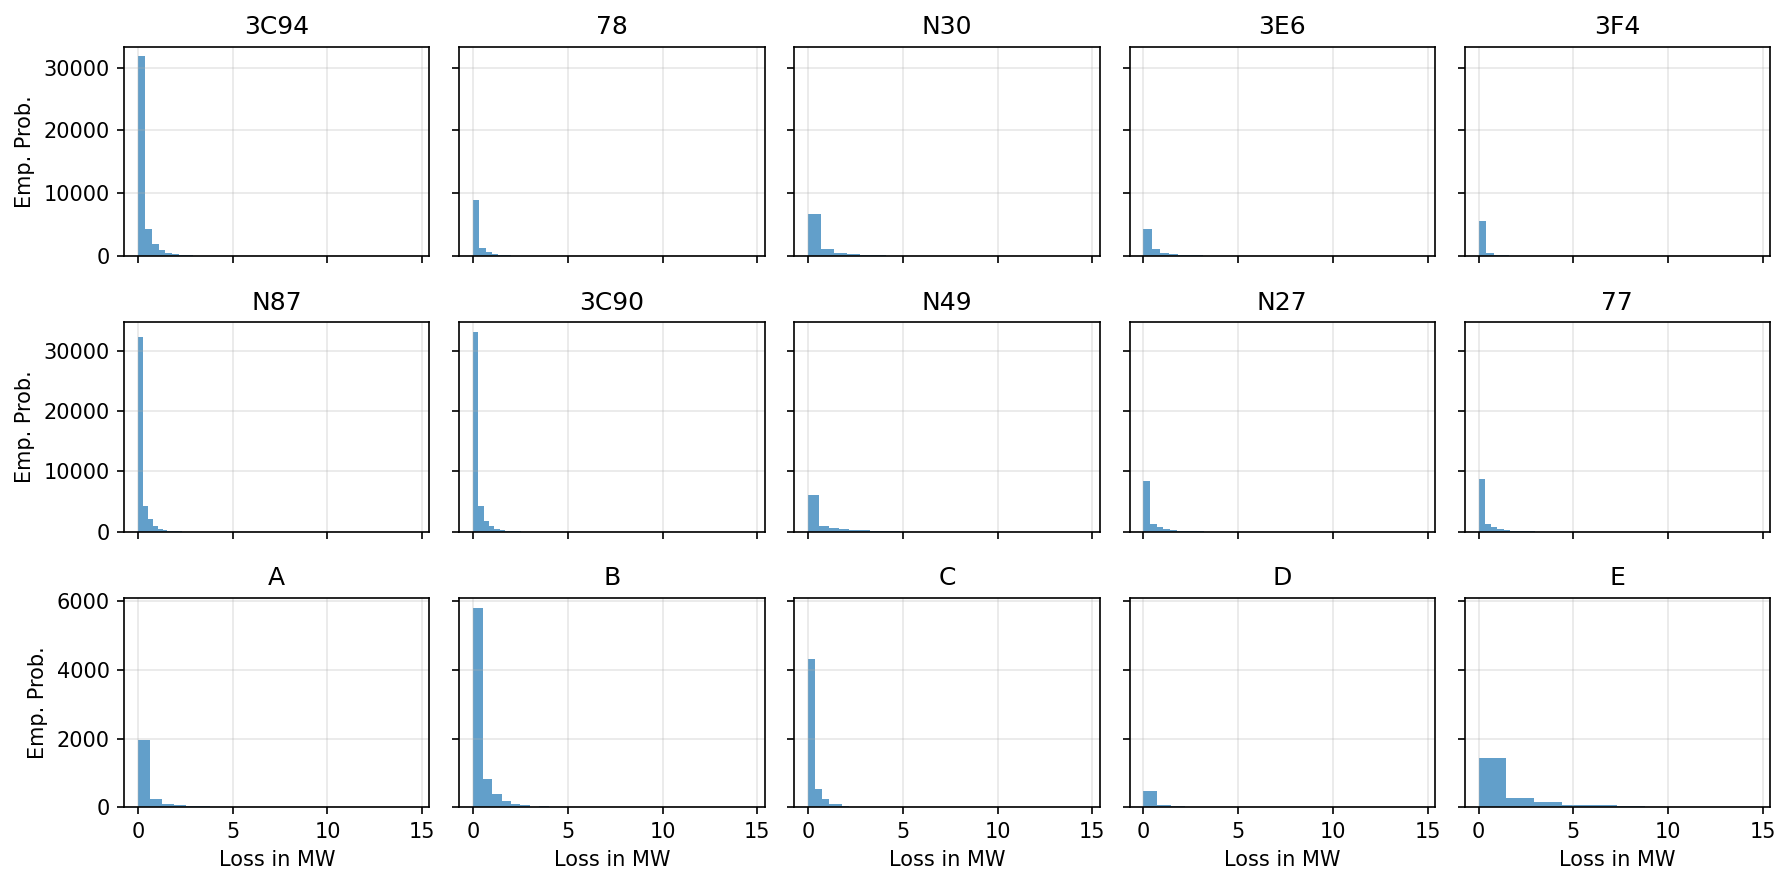

In [12]:
# Histogram of loss
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=150, sharex=True, sharey="row", figsize=(12, 6))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material", sort=False)):
    ax.hist(mat_df.ploss*1e-6, alpha=.7)
    ax.set_title(mat_lbl)
for ax in axes[:, 0]:
    ax.set_ylabel("Emp. Prob.")
for ax in axes[-1, :]:
    ax.set_xlabel("Loss in MW")
fig.tight_layout()

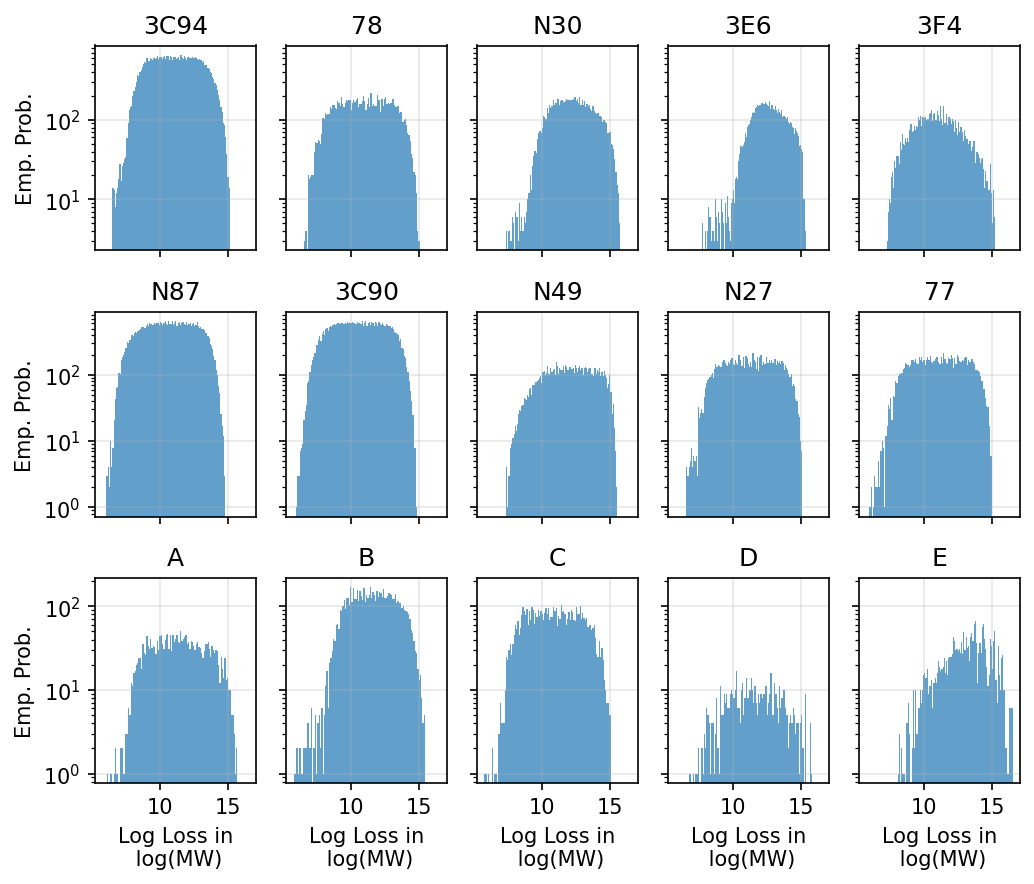

In [25]:
# Histogram of log loss
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=150, sharex=True, sharey="row", figsize=(7, 6))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material", sort=False)):
    ax.hist(np.log(mat_df.ploss), alpha=.7, bins=100)
    ax.set_title(mat_lbl)
    ax.set_yscale('log')
for ax in axes[:, 0]:
    ax.set_ylabel("Emp. Prob.")
for ax in axes[-1, :]:
    ax.set_xlabel("Log Loss in\n log(MW)")
fig.tight_layout()

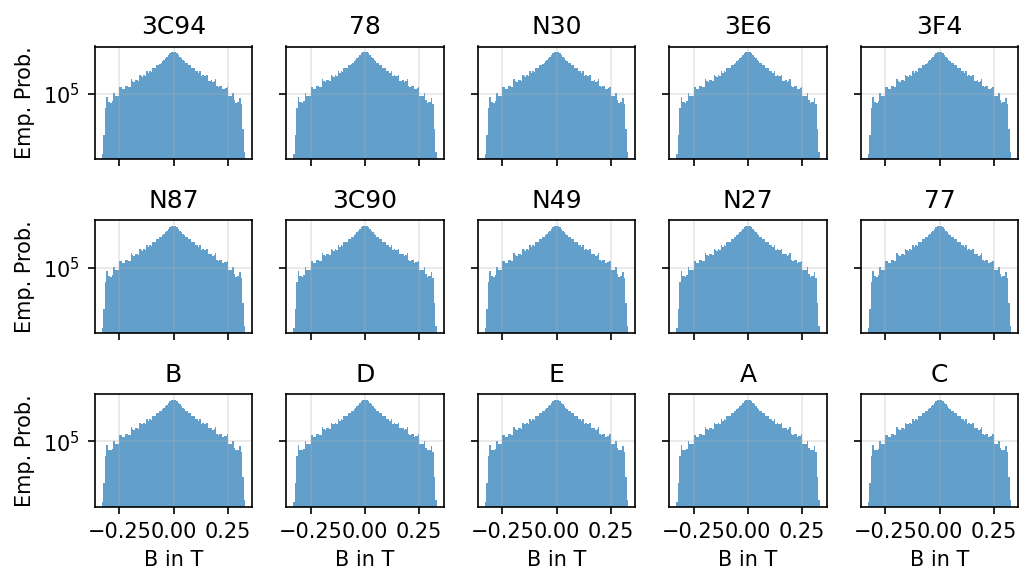

In [24]:
# Histogram of B curves
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=150, sharex=True, sharey="row", figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material", sort=False)):
    ax.hist(np.sinh(1*np.arcsinh(full_b.ravel())), alpha=.7, bins=100, log=True)
    ax.set_title(mat_lbl)
for ax in axes[:, 0]:
    ax.set_ylabel("Emp. Prob.")
for ax in axes[-1, :]:
    ax.set_xlabel("B in T")
fig.tight_layout()

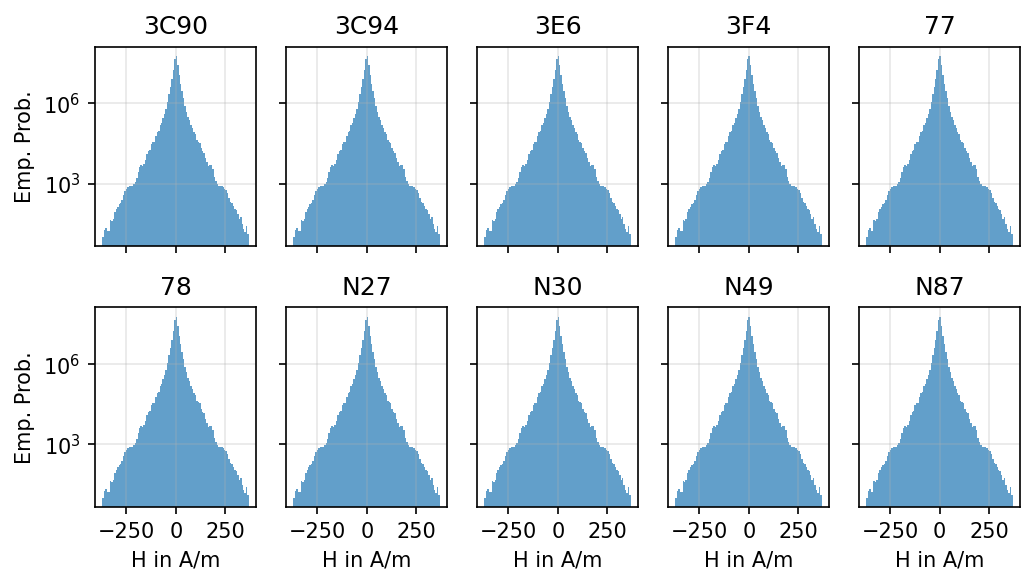

In [12]:
# Histogram of H curves
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    ax.hist(full_h.ravel(), alpha=.7, bins=100, log=True)
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Emp. Prob.")
axes[1, 0].set_ylabel("Emp. Prob.")
for ax in axes[-1, :]:
    ax.set_xlabel("H in A/m")
fig.tight_layout()

### 2way scatter plots

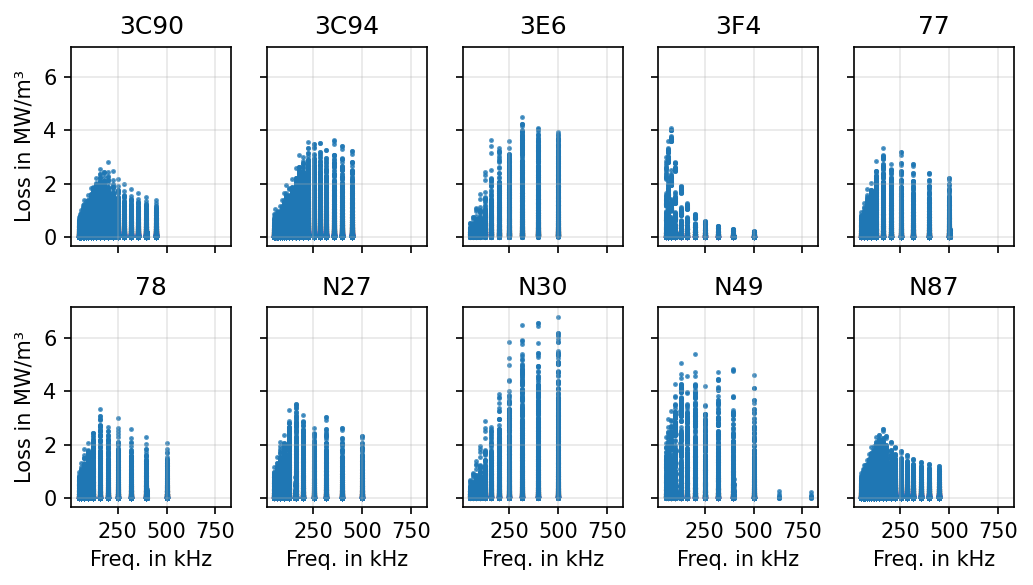

In [74]:
# 2-way scatters
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    ax.scatter(mat_df.freq/1000, mat_df.ploss*1e-6, alpha=.7, s=2.0)
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Loss in MW/m³")
axes[1, 0].set_ylabel("Loss in MW/m³")
for ax in axes[-1, :]:
    ax.set_xlabel("Freq. in kHz")
fig.tight_layout()

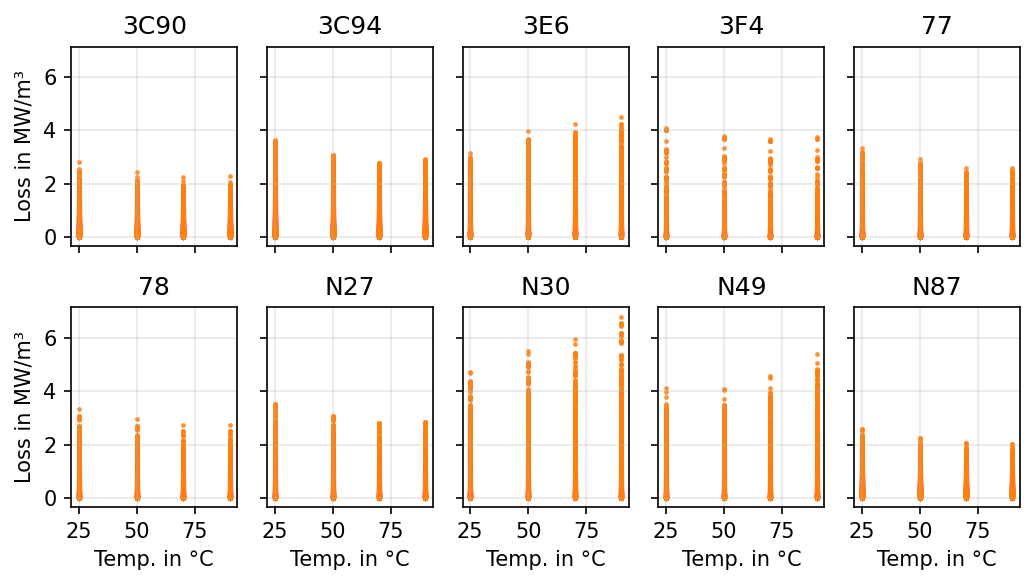

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    ax.scatter(mat_df.temp, mat_df.ploss*1e-6, alpha=.7, s=2.0, color='tab:orange')
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Loss in MW/m³")
axes[1, 0].set_ylabel("Loss in MW/m³")
for ax in axes[-1, :]:
    ax.set_xlabel("Temp. in °C")
fig.tight_layout()

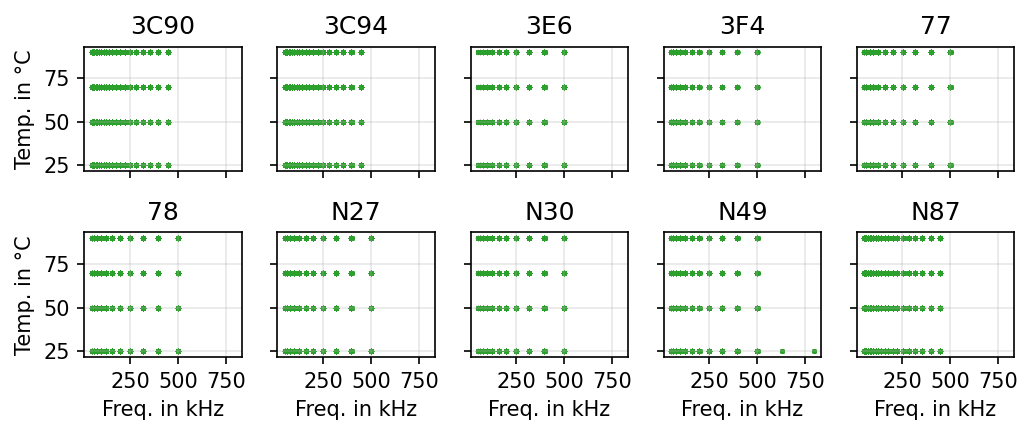

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 3))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    ax.scatter(mat_df.freq*1e-3, mat_df.temp, alpha=.7, s=2.0, color='tab:green')
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Temp. in °C")
axes[1, 0].set_ylabel("Temp. in °C")
for ax in axes[-1, :]:
    ax.set_xlabel("Freq. in kHz")
fig.tight_layout()

## Visualize B-H-Curves

In [3]:
SUB_B_COLS = [f"B_t_{k}" for k in range(0,1024, 4)]
SUB_H_COLS = [f"H_t_{k}" for k in range(0,1024, 4)]

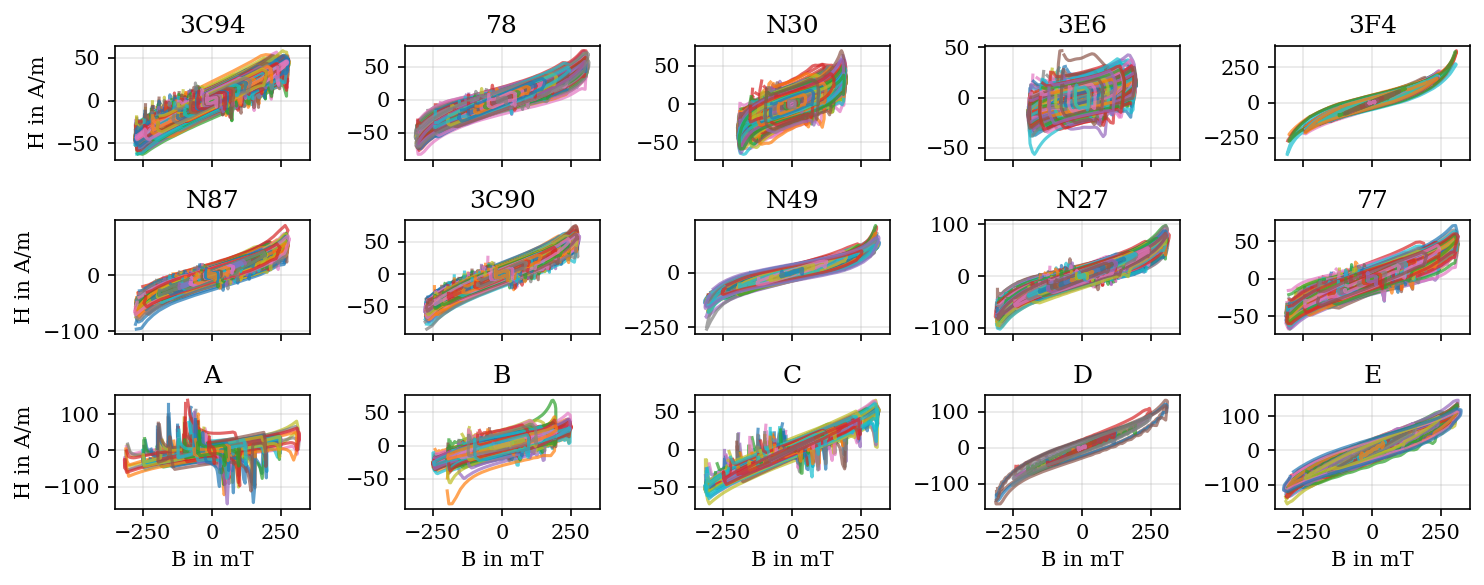

In [4]:
# plot bh curves unnormalized
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=150, sharex=True, sharey=False, figsize=(10, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material", sort=False)):
    b, h = mat_df.loc[::10, SUB_B_COLS].to_numpy(), mat_df.loc[::10, SUB_H_COLS].to_numpy()
    ax.plot(b.T*1000, h.T, alpha=.7)
    ax.set_title(mat_lbl)
for ax in axes[:, 0]:
    ax.set_ylabel("H in A/m")
for ax in axes[-1, :]:
    ax.set_xlabel("B in mT")
fig.tight_layout()

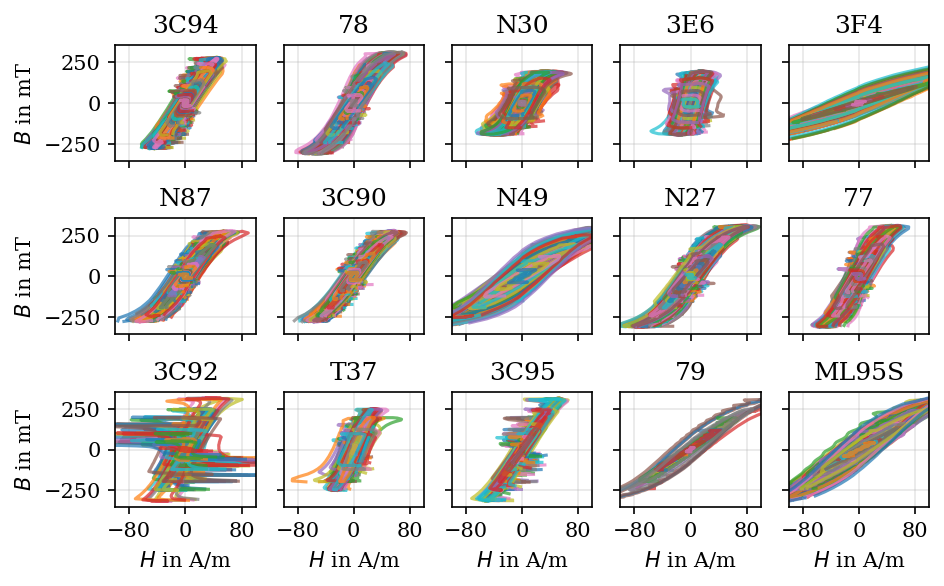

In [6]:
# plot bh curves unnormalized (for paper with ylim)

true_mats_d = {'A': "3C92", "B": "T37", "C": "3C95", "D": "79", "E":"ML95S"}

fig, axes = plt.subplots(nrows=3, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material", sort=False)):
    b, h = mat_df.loc[::10, SUB_B_COLS].to_numpy(), mat_df.loc[::10, SUB_H_COLS].to_numpy()
    ax.plot(h.T, b.T*1000 , alpha=.7)
    ax.set_title(true_mats_d.get(mat_lbl, mat_lbl))
    ax.set_xlim(-100, 100)
    ax.set_xticks(np.linspace(-80, 80, 3))
for ax in axes[-1, :]:
    ax.set_xlabel("$H$ in A/m")
for ax in axes[:, 0]:
    ax.set_ylabel("$B$ in mT")
fig.align_ylabels()
fig.subplots_adjust(hspace=0.5)
#fig.tight_layout()
fig.savefig(IMG_PATH / "original_bh_curves.png", dpi=200, bbox_inches="tight")

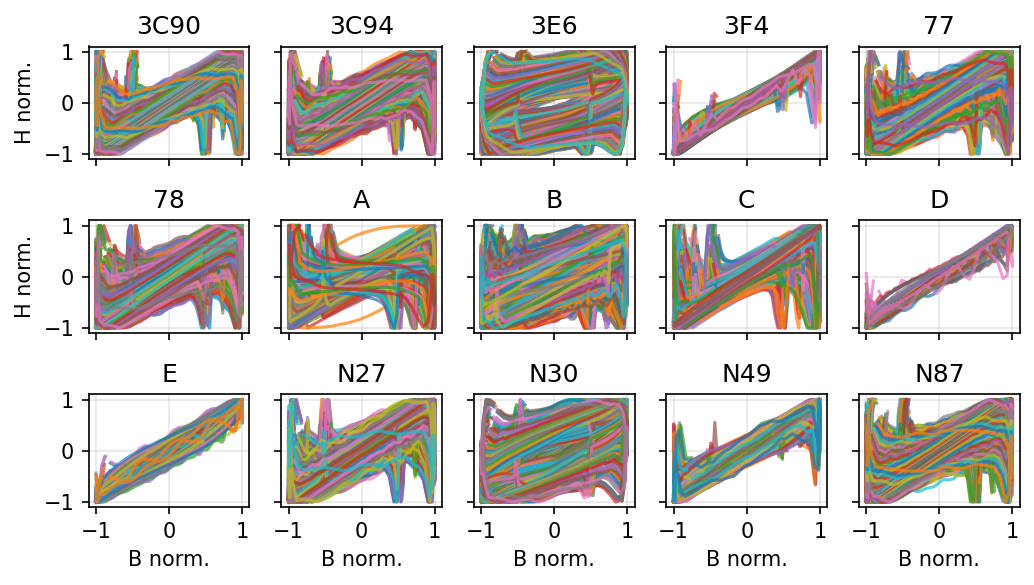

In [12]:
# BH curves normalized on maximum amplitude
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    b, h = mat_df.loc[::10, SUB_B_COLS].to_numpy(), mat_df.loc[::10, SUB_H_COLS].to_numpy()
    ax.plot((b/np.abs(b).max(axis=1).reshape(-1, 1)).T, (h/np.abs(h).max(axis=1).reshape(-1, 1)).T, alpha=.7)
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("H norm.")
axes[1, 0].set_ylabel("H norm.")
for ax in axes[-1, :]:
    ax.set_xlabel("B norm.")
fig.tight_layout()

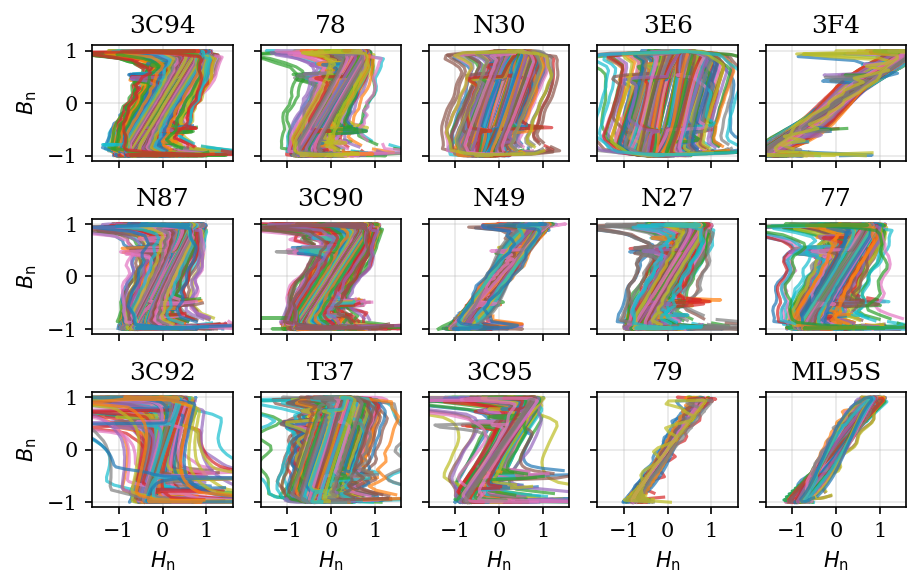

In [7]:
# BH curves normalized on maximum amplitude per profile as estimated from B curve
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material", sort=False)):
    b, h = mat_df.loc[::20, SUB_B_COLS].to_numpy(), mat_df.loc[::20, SUB_H_COLS].to_numpy()
    ax.plot((h/(np.minimum(np.abs(h).max(), 150) * np.abs(b).max(axis=1).reshape(-1,1)/np.abs(b).max())).T,
            (b/np.abs(b).max(axis=1).reshape(-1, 1)).T, 
              alpha=.7)
    ax.set_title(true_mats_d.get(mat_lbl, mat_lbl))
    ax.set_xlim(-1.6, 1.6)
    #ax.text(0.9* ax.get_xlim()[-1], 0.9 * ax.get_ylim()[-1], s=mat_lbl, verticalalignment="top",
    #            horizontalalignment="right")

    
for ax in axes[:, 0]:
    ax.set_ylabel("$B_\mathrm{n}$")
for ax in axes[-1, :]:
    ax.set_xlabel("$H_\mathrm{n}$")
fig.align_ylabels()
fig.subplots_adjust(hspace=0.5)
#fig.tight_layout()
fig.savefig(IMG_PATH / "scaled_bh_area.png", dpi=200, bbox_inches="tight")

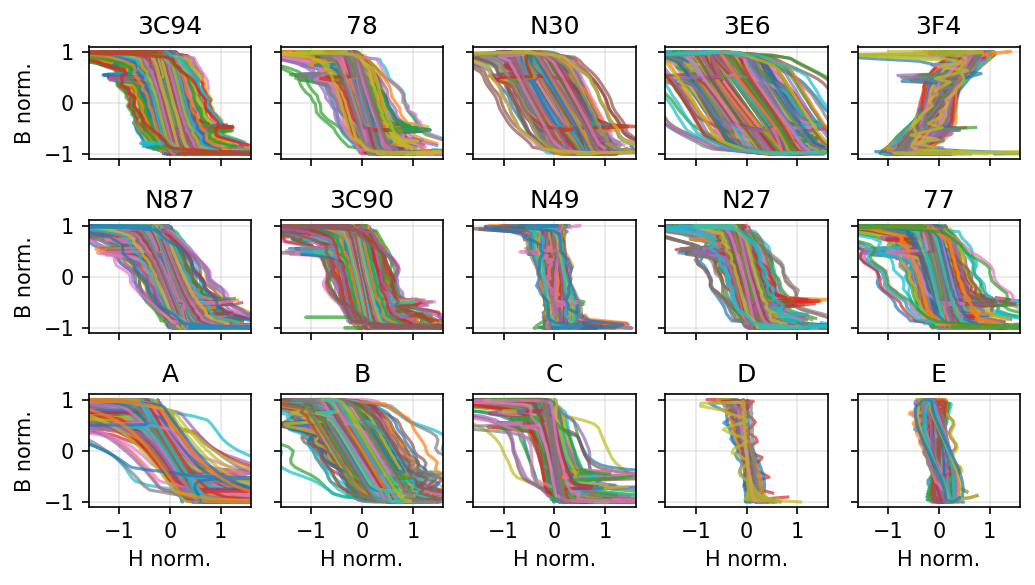

In [37]:
# BH curves normalized on maximum amplitude per profile as estimated from B curve, and subtracted from adhoc feature
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material", sort=False)):
    b, h = mat_df.loc[::20, SUB_B_COLS].to_numpy(), mat_df.loc[::20, SUB_H_COLS].to_numpy()
    scaled_b = (b/np.abs(b).max(axis=1).reshape(-1, 1)).T
    scaled_h_n_subbed = (h/(np.minimum(np.abs(h).max(), 150) * np.abs(b).max(axis=1).reshape(-1,1)/np.abs(b).max())).T - scaled_b
    ax.plot(scaled_h_n_subbed, scaled_b, alpha=.7)
    ax.set_title(mat_lbl)
    ax.set_xlim(-1.6, 1.6)
for ax in axes[:, 0]:
    ax.set_ylabel("$b_\mathrm{n}$")
for ax in axes[-1, :]:
    ax.set_xlabel("$h_\mathrm{n}$")
fig.tight_layout()

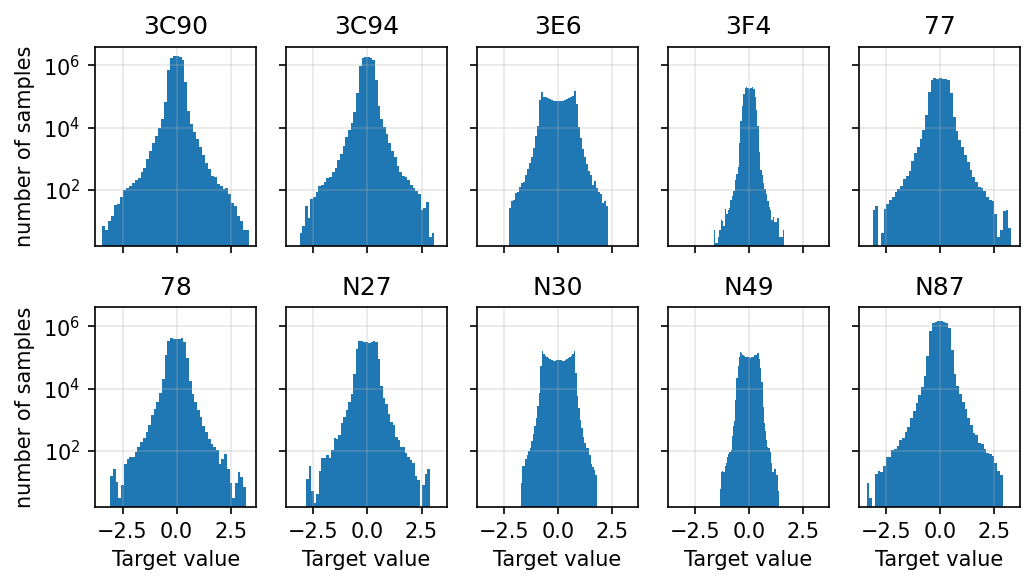

In [9]:
# how do differences H-B scatter per material?
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    b, h = mat_df.loc[:, [f"B_t_{k}" for k in range(0,1024, 4)]].to_numpy(), mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024, 4)]].to_numpy()
    ax.hist(((h/(np.abs(h).max() * np.abs(b).max(axis=1).reshape(-1,1)/np.abs(b).max())).T - (b/np.abs(b).max(axis=1).reshape(-1, 1)).T).ravel(),
            bins=50)
    ax.set_title(mat_lbl)
    ax.set_yscale('log')
axes[0, 0].set_ylabel("number of samples")
axes[1, 0].set_ylabel("number of samples")
for ax in axes[-1, :]:
    ax.set_xlabel("Target value")
fig.tight_layout()

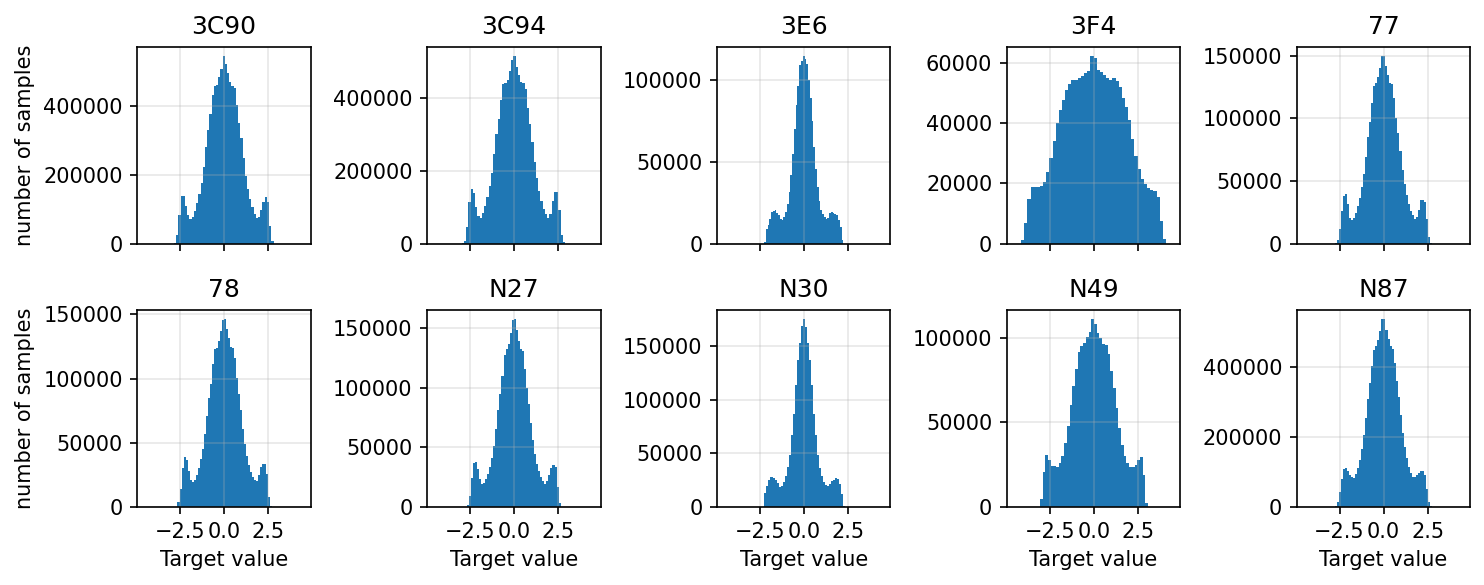

In [15]:
# how do differences H-B_tantan scatter per material?
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=False, figsize=(10, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    b, h = mat_df.loc[:, [f"B_t_{k}" for k in range(0,1024, 4)]].to_numpy(), mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024, 4)]].to_numpy()
    scaled_b = (b/np.abs(b).max(axis=1).reshape(-1, 1)).T
    scaled_h = (h/(np.minimum(np.abs(h).max(), 150) * np.abs(b).max(axis=1).reshape(-1,1)/np.abs(b).max())).T
    scaled_h_n_subbed = scaled_h + np.tan(0.9*np.tan(scaled_b))/3
    ax.hist(scaled_h_n_subbed.ravel(), bins=50)
    ax.set_title(mat_lbl)
    #ax.set_yscale('log')
axes[0, 0].set_ylabel("number of samples")
axes[1, 0].set_ylabel("number of samples")
for ax in axes[-1, :]:
    ax.set_xlabel("Target value")
fig.tight_layout()

## Distributions (2)
Consider B_max and H_max

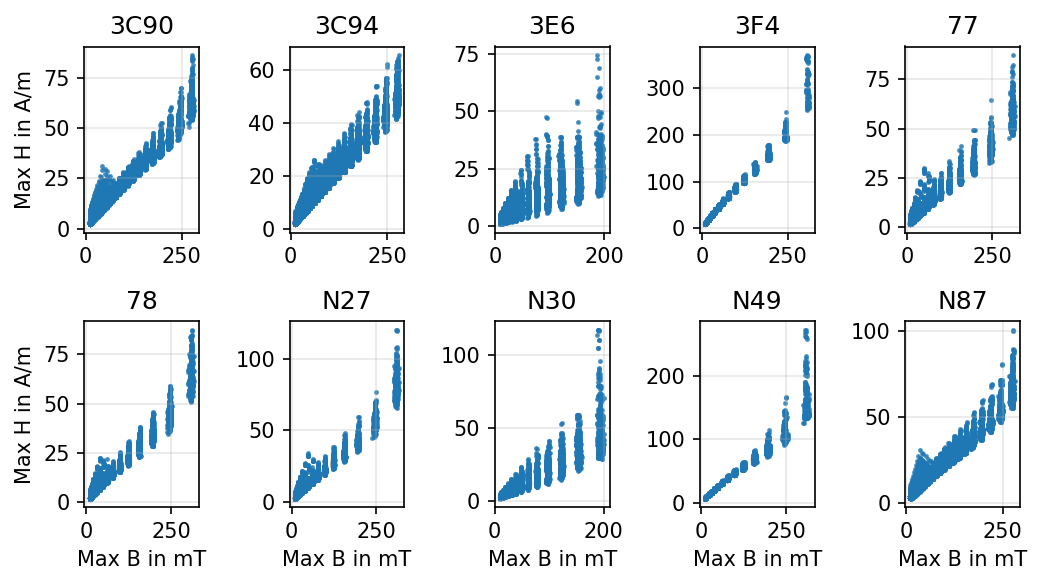

In [99]:
# Max H over B Max
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=False, sharey=False, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    b, h = mat_df.loc[:, [f"B_t_{k}" for k in range(0,1024)]].to_numpy(), mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024)]].to_numpy()
    bmax = np.max(np.abs(b), axis=1)
    hmax = np.max(np.abs(h), axis=1)
    ax.scatter(bmax*1000, hmax, alpha=.7, s=2.0)
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Max H in A/m")
axes[1, 0].set_ylabel("Max H in A/m")
for ax in axes[-1, :]:
    ax.set_xlabel("Max B in mT")
fig.tight_layout()

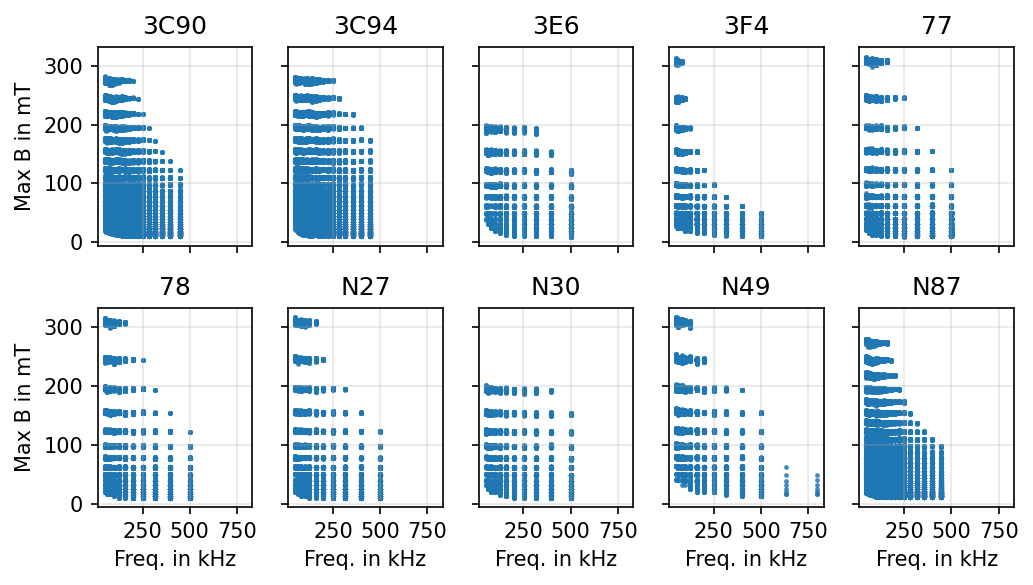

In [110]:
# max B over Frequency
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    b = mat_df.loc[:, [f"B_t_{k}" for k in range(0,1024)]].to_numpy() #, mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024)]].to_numpy()
    bmax = np.max(np.abs(b), axis=1)
    #hmax = np.max(np.abs(h), axis=1)
    #ax.scatter(mat_df.freq*1e3, hmax, alpha=.7, s=2.0, label='H')
    ax.scatter(mat_df.freq*1e-3, bmax*1000, alpha=.7, s=2.0, label='B', )
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Max B in mT")
axes[1, 0].set_ylabel("Max B in mT")
for ax in axes[-1, :]:
    ax.set_xlabel("Freq. in kHz")
fig.tight_layout()

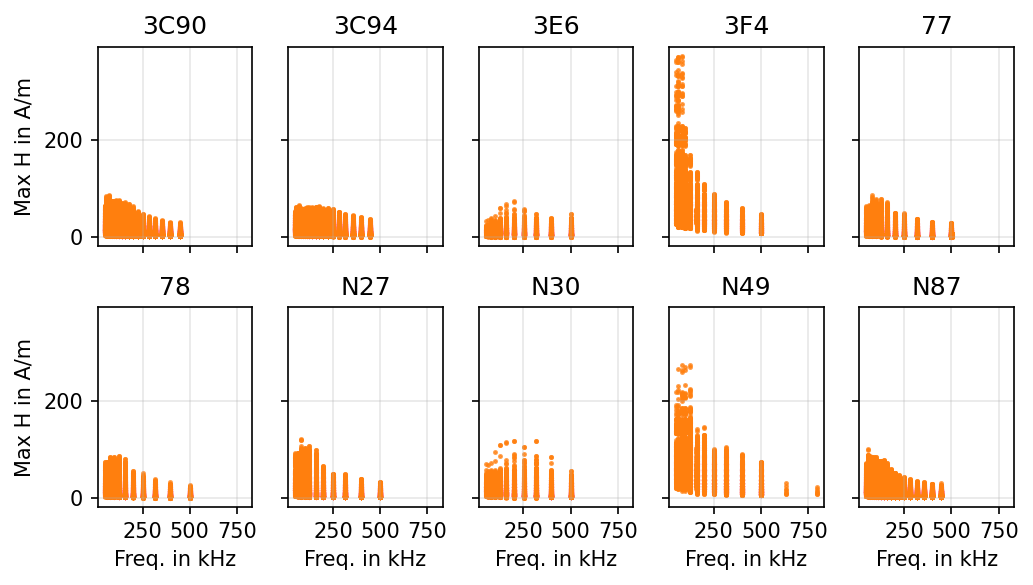

In [112]:
# max H over Frequency
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    h = mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024)]].to_numpy()
    
    hmax = np.max(np.abs(h), axis=1)
    ax.scatter(mat_df.freq*1e-3, hmax, alpha=.7, s=2.0, label='H', color='tab:orange')
    
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Max H in A/m")
axes[1, 0].set_ylabel("Max H in A/m")
for ax in axes[-1, :]:
    ax.set_xlabel("Freq. in kHz")
fig.tight_layout()

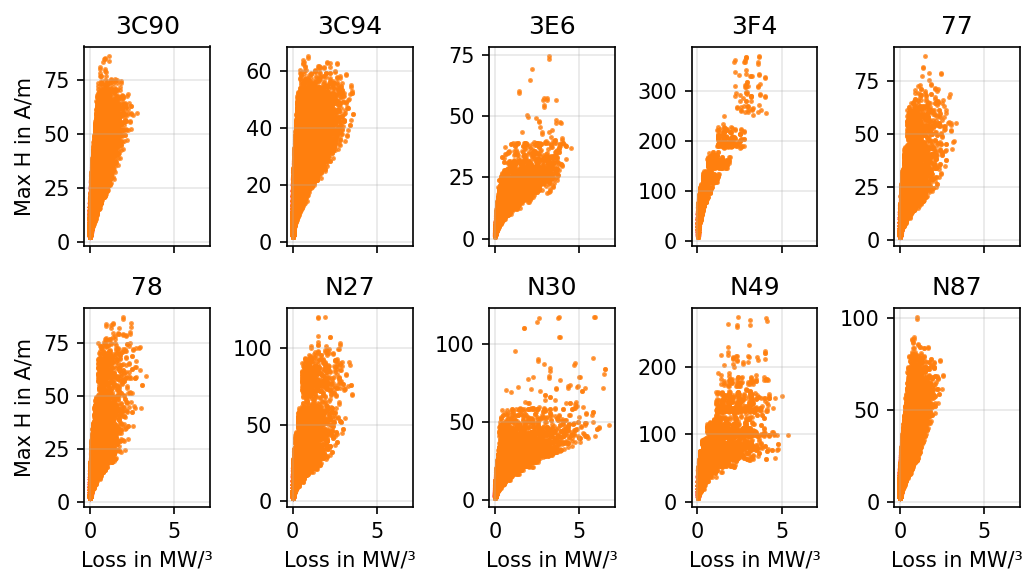

In [114]:
# max H over power loss
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=False, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    h = mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024)]].to_numpy()
    
    hmax = np.max(np.abs(h), axis=1)
    ax.scatter(mat_df.ploss*1e-6, hmax, alpha=.7, s=2.0, label='H', color='tab:orange')
    
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Max H in A/m")
axes[1, 0].set_ylabel("Max H in A/m")
for ax in axes[-1, :]:
    ax.set_xlabel("Loss in MW/³")
fig.tight_layout()

## Estimate waveforms

In [7]:
waveforms = get_waveform_est(full_b)

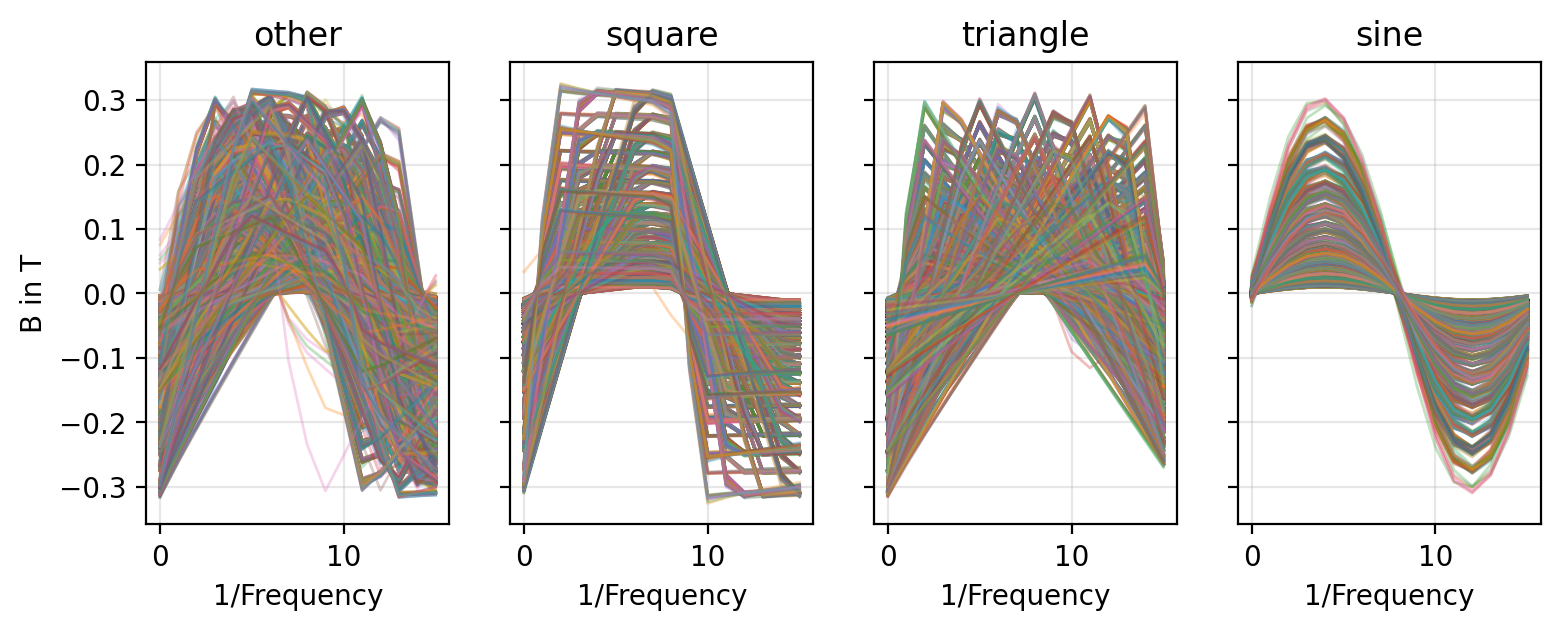

In [8]:
fig, axes = plt.subplots(1, 4, dpi=200, figsize=(9, 3), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    ax.plot(full_b[waveforms == i, ::64].T, alpha=0.3, lw=1.0)

axes[0].set_ylabel("B in T")
for ax in axes:
    ax.set_xlabel("1/Frequency")
for i, lbl in enumerate(['other', 'square', 'triangle', 'sine']):
    axes[i].set_title(lbl)

In [9]:
np.unique(waveforms, return_counts=True)

(array([0, 1, 2, 3]), array([106464,  28408,  61064,   8588]))

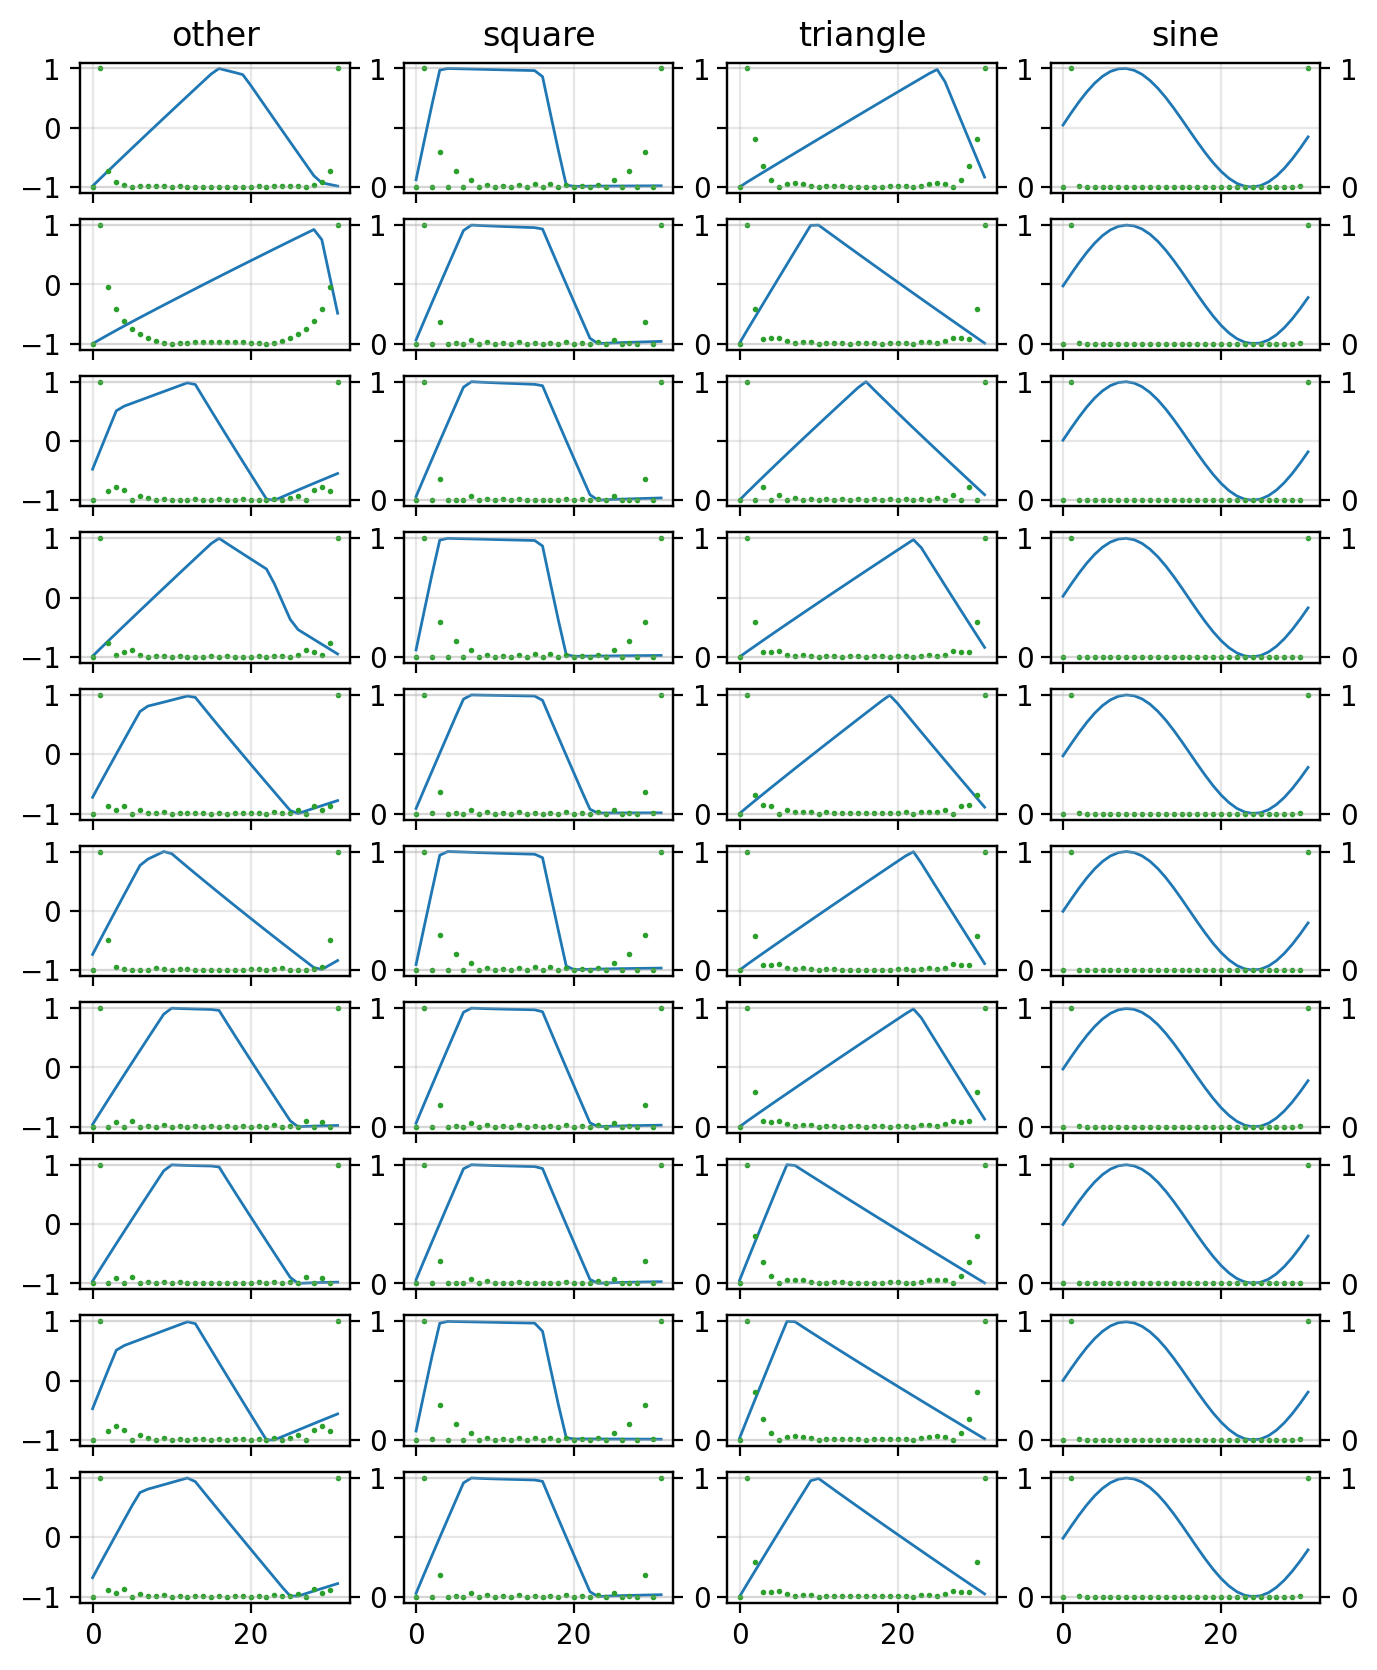

In [91]:
# look at some "other" examples, maybe it can be improved?
n_subsample = 32
fig, axes = plt.subplots(10, 4, dpi=200, figsize=(8, 10), sharex=True, sharey=True)
for wform_k, wform_lbl in enumerate(['other', 'square', 'triangle', 'sine']):
    wform_b_waves = full_b[waveforms == wform_k, ::n_subsample][-10:]
    wform_b_waves /= np.abs(wform_b_waves).max(axis=1, keepdims=True)
    for b_i, b_wave in enumerate(wform_b_waves):
        ax = axes[b_i, wform_k]
        ax.plot(b_wave, lw=1.0, color='tab:blue')
        wave_ft = np.fft.fft(b_wave)
        wave_ft_norm = np.abs(wave_ft) / np.abs(wave_ft).max()
        ax2 = ax.twinx()
        ax2.scatter(np.arange(wave_ft_norm.size),#np.fft.fftfreq(b_wave.size, d=1), 
                wave_ft_norm , color='tab:green', s=1.0)
        
    axes[0, wform_k].set_title(wform_lbl)

Text(3, -0.95, '13146 recovered')

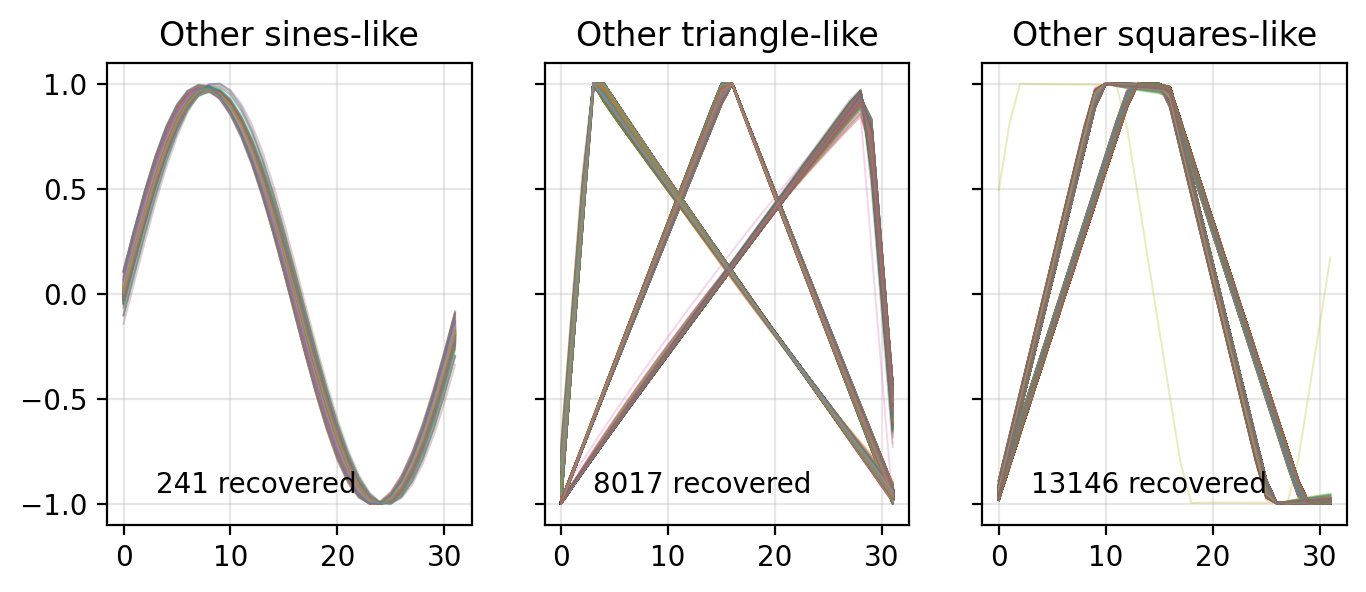

In [122]:
other_b = full_b[waveforms == 0, ::n_subsample]
other_b /= np.abs(other_b).max(axis=1, keepdims=True)
other_b_ft = np.abs(np.fft.fft(other_b, axis=1))
other_b_ft /= other_b_ft.max(axis=1, keepdims=True)
idx_of_newly_identified_sines = np.all((other_b_ft[:, 3:10] < 0.03) & (other_b_ft[:, [2]] < 0.2), axis=1)
idx_of_newly_identified_triangs = np.all(((other_b_ft[:, 1:8] - other_b_ft[:, 2:9]) > 0), axis=1) | np.all(((other_b_ft[:, 1:8:2] > 1e-2) & (other_b_ft[:, 2:9:2] < 1e-2)), axis=1)
idx_of_newly_identified_triangs = idx_of_newly_identified_triangs & ~idx_of_newly_identified_sines
idx_of_newly_identified_squares = np.all((other_b_ft[:, 1:4:2] > 1e-2) & (other_b_ft[:, 2:5:2] < 1e-3), axis=1)
idx_of_newly_identified_squares = idx_of_newly_identified_squares & ~idx_of_newly_identified_sines & ~idx_of_newly_identified_triangs
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8, 3))
axes[0].plot(other_b[idx_of_newly_identified_sines, :].T, alpha=0.3, lw=.7)
axes[0].set_title('Other sines-like')
axes[0].text(3, -0.95, f"{np.sum(idx_of_newly_identified_sines)} recovered")
axes[1].plot(other_b[idx_of_newly_identified_triangs, :].T, alpha=0.3, lw=.7)
axes[1].set_title('Other triangle-like')
axes[1].text(3, -0.95, f"{np.sum(idx_of_newly_identified_triangs)} recovered")
axes[2].plot(other_b[idx_of_newly_identified_squares, :].T, alpha=0.3, lw=.7)
axes[2].set_title('Other squares-like')
axes[2].text(3, -0.95, f"{np.sum(idx_of_newly_identified_squares)} recovered")

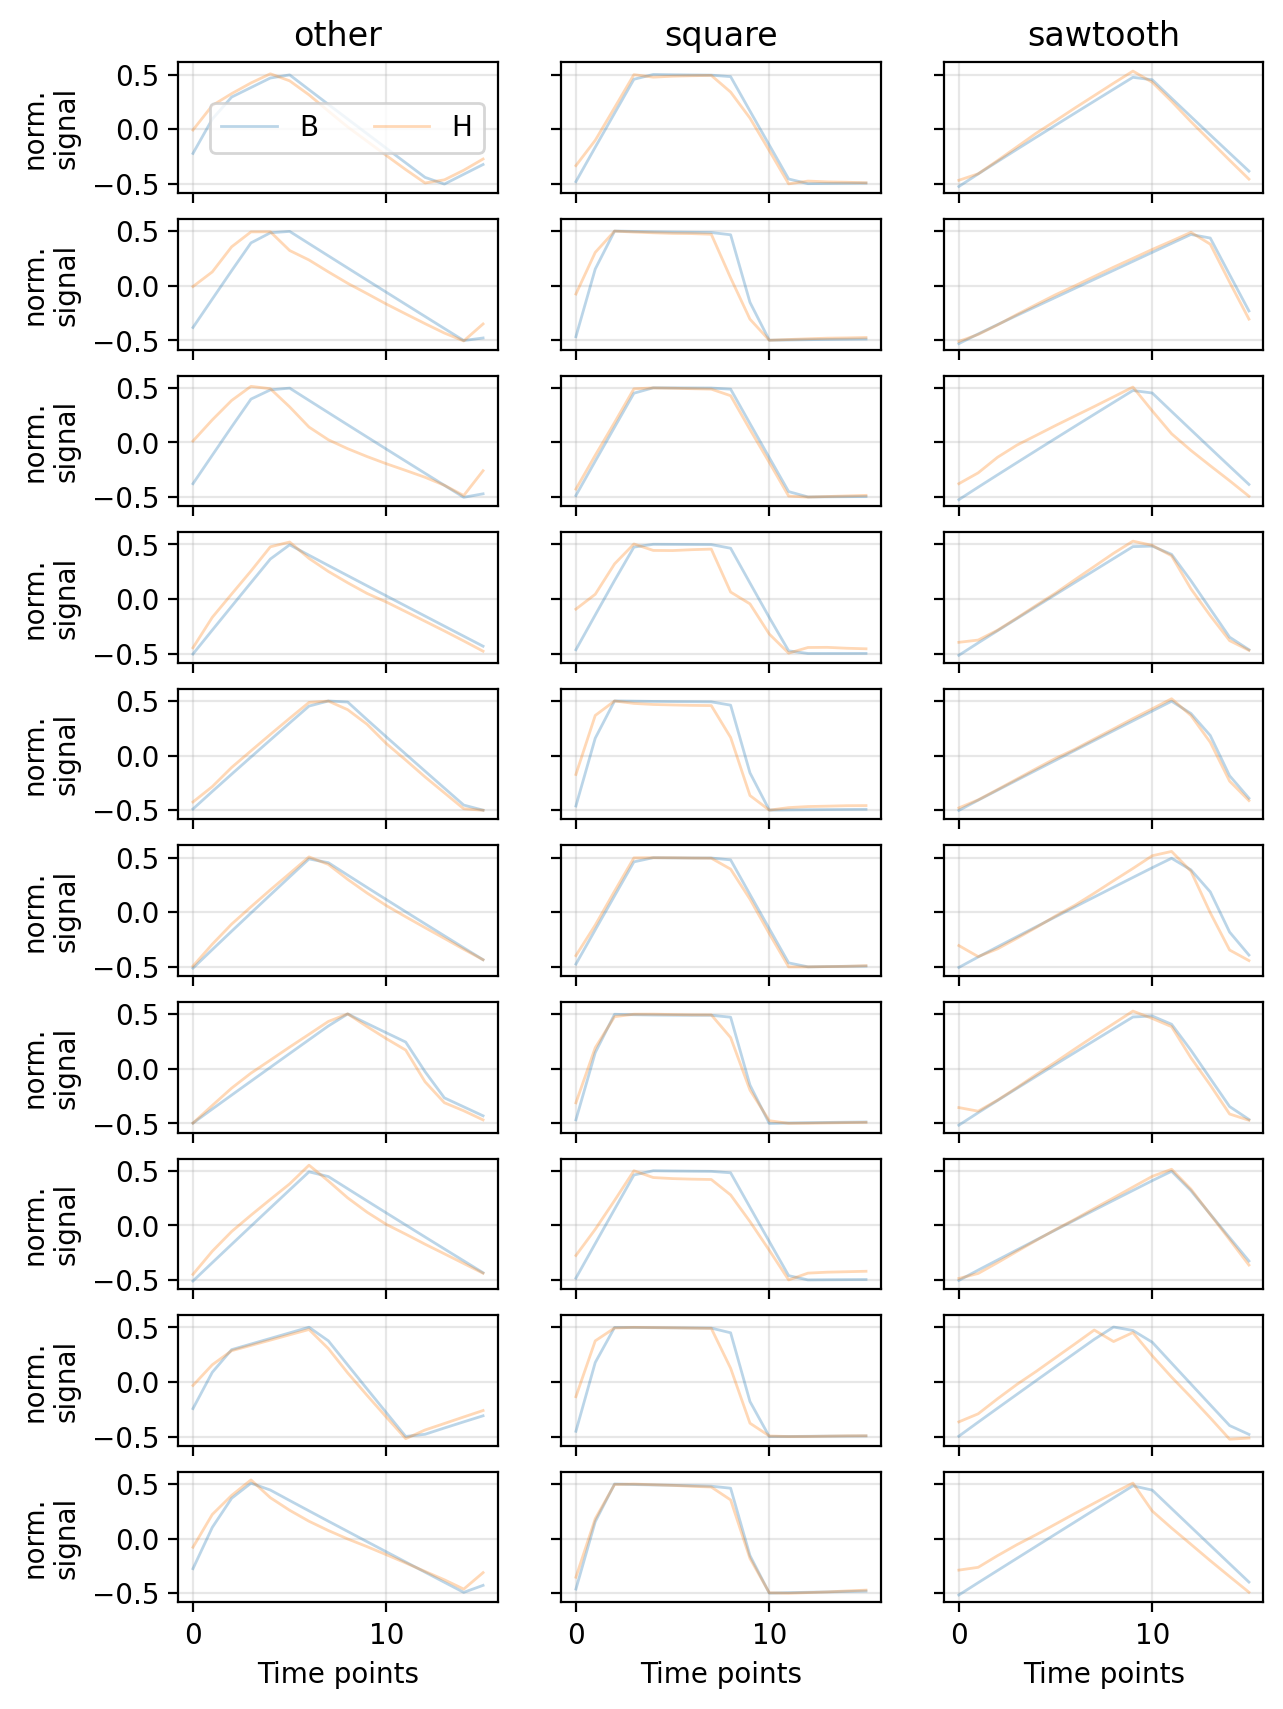

In [68]:
# some examples per waveform

fig, axes = plt.subplots(10, len(template_lbls), dpi=200, figsize=(7, 10), sharex=True, sharey=True)

for wav_i, wav_df in ds.groupby("waveform"):
    for i, j in zip(range(10), np.random.choice(np.arange(len(wav_df)), 10, replace=False)):
        b = 1000*wav_df.iloc[j, :].loc[[f"B_t_{t}" for t in range(0, 1024, 64)]].to_numpy()
        b /= b.max() - b.min()
        axes[i, wav_i].plot(b, alpha=0.3, lw=1.0, label='B')
        h = wav_df.iloc[j, :].loc[[f"H_t_{t}" for t in range(0, 1024, 64)]].to_numpy()
        h /= h.max() - h.min()
        axes[i, wav_i].plot(h, alpha=0.3, lw=1.0, label='H')
        if wav_i == 0 and i == 0:
            axes[i, wav_i].legend(ncols=2)
for i in range(10):
    axes[i, 0].set_ylabel("norm.\nsignal")
for ax in axes[-1, :]:
    ax.set_xlabel("Time points")
for i, lbl in enumerate(template_lbls):
    axes[0, i].set_title(lbl)

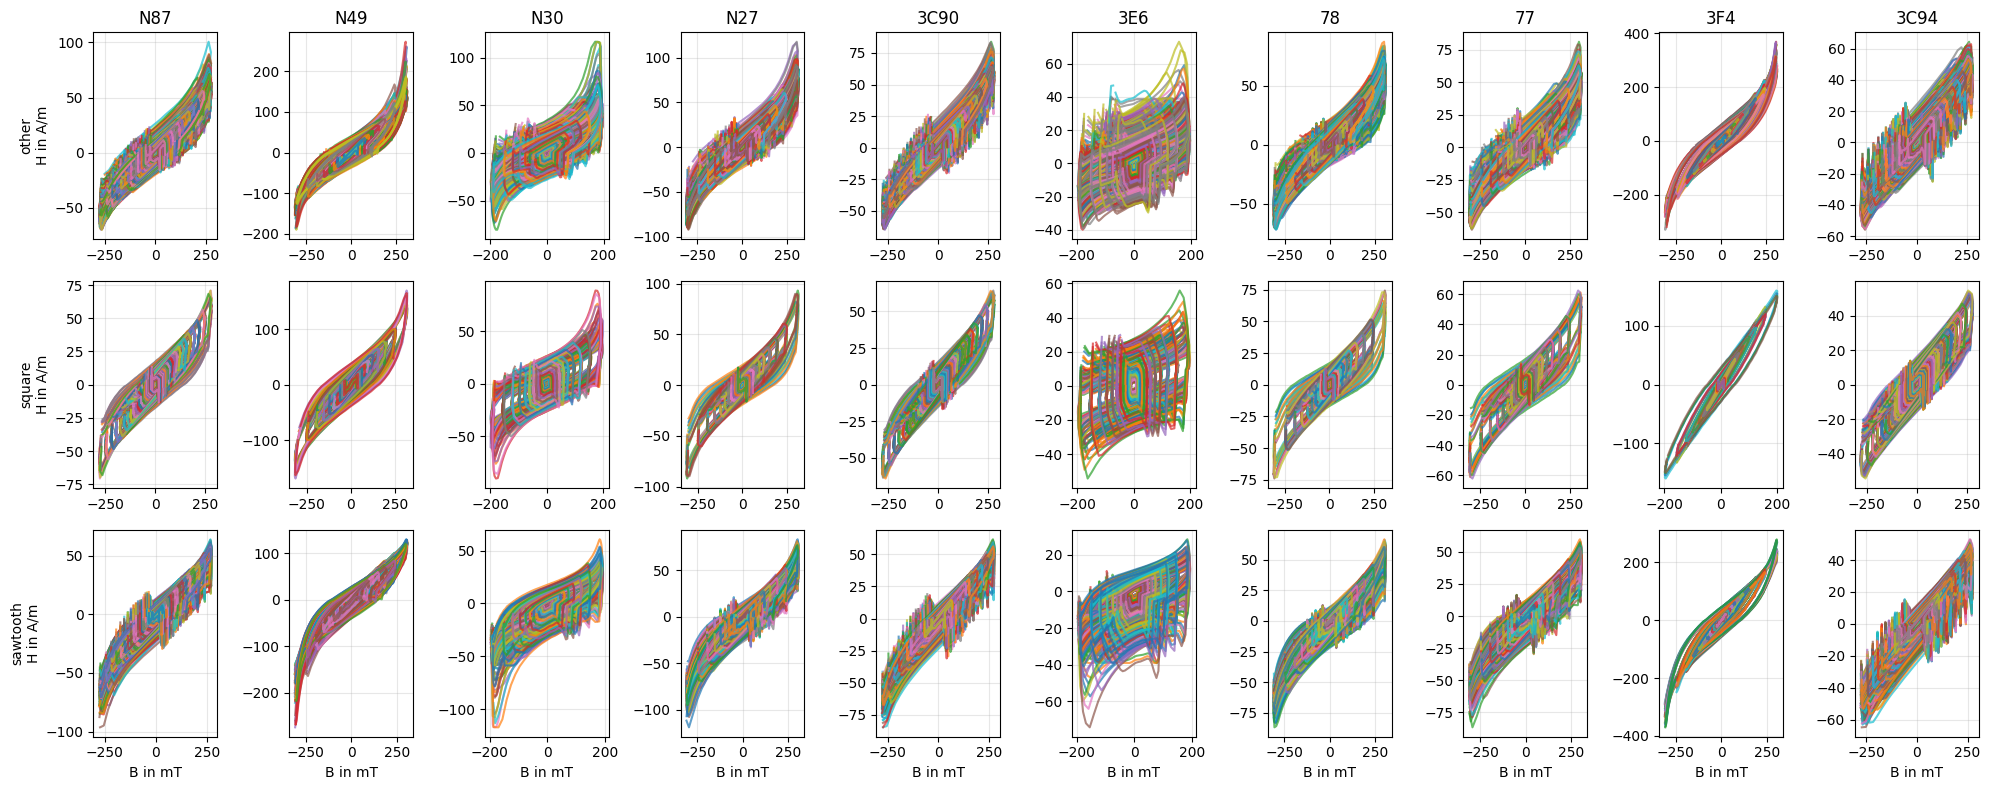

In [177]:
# B-H polygon per material and per waveform
fig, axes = plt.subplots(nrows=len(template_lbls), ncols=10, dpi=100, sharex=False, sharey=False, figsize=(20, 8))
mat_lbls = ds.material.unique().tolist()
for (mat_lbl, wav_lbl), df_ in ds.groupby(["material", 'waveform']):
    b, h = df_.loc[:, [f"B_t_{k}" for k in range(0,1024, 4)]].to_numpy(), df_.loc[:, [f"H_t_{k}" for k in range(0,1024, 4)]].to_numpy()
    col_i = mat_lbls.index(mat_lbl)
    axes[wav_lbl, col_i].plot(b.T*1000, h.T, alpha=.7)
    
for ax, wav_lbl in zip(axes[:, 0], template_lbls):
    ax.set_ylabel(f"{wav_lbl}\nH in A/m")
for ax, m in zip(axes[0, :], mat_lbls):
    ax.set_title(m)
for ax in axes[-1, :]:
    ax.set_xlabel("B in mT")
fig.tight_layout()

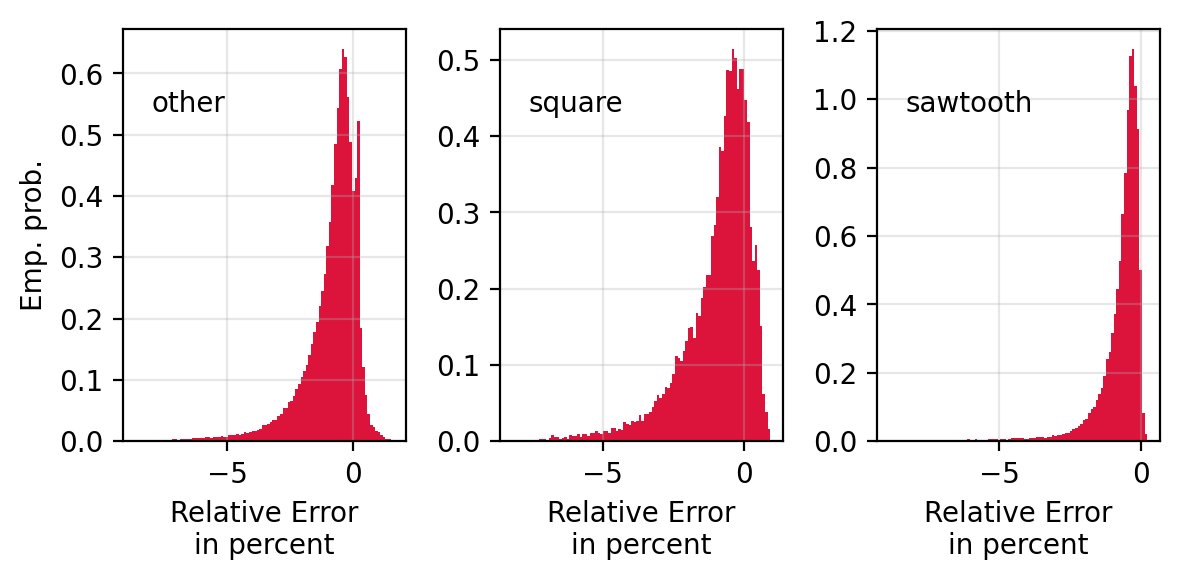

In [168]:
# computed area of the B-H polygon - analysis
fig, axes = plt.subplots(1, len(template_lbls), sharex=False, sharey=False, dpi=200, figsize=(6, 3))
#plt.figure(dpi=200)

ds["computed_bh_area"] = get_bh_integral(ds)
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("waveform")):    
    calc_error = ( mat_df.computed_bh_area - mat_df.ploss) / mat_df.ploss
    ax.hist(calc_error*100 , color='crimson', bins=100, density=True)
    ax.text(0.1, 0.8, s=template_lbls[int(mat_lbl)], transform=ax.transAxes )
    if ax == axes[0]:
        ax.set_ylabel("Emp. prob.")
    ax.set_xlabel("Relative Error\nin percent")
fig.tight_layout()

Text(0, 0.5, 'Rel. Error in percent')

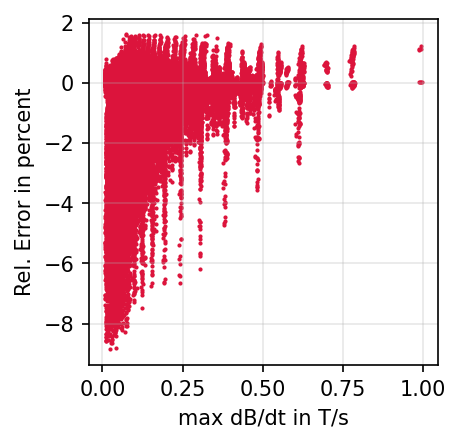

In [5]:
#ds["waveform"] = cls_estimate
ds["computed_bh_area"] = get_bh_integral(ds)
ds["max_dBdt"] = np.abs(full_b[:, 1:] - full_b[:, :-1]).max(axis=1)*ds.freq/1024
ds["ploss_rel_error"] = ( ds.computed_bh_area - ds.ploss) / ds.ploss

plt.figure(dpi=150, figsize=(3,3))
plt.scatter(ds.max_dBdt, ds.ploss_rel_error*100, s=1.0, color='crimson')
plt.xlabel("max dB/dt in T/s")
plt.ylabel("Rel. Error in percent")

Text(0, 0.5, 'Rel. Error in percent')

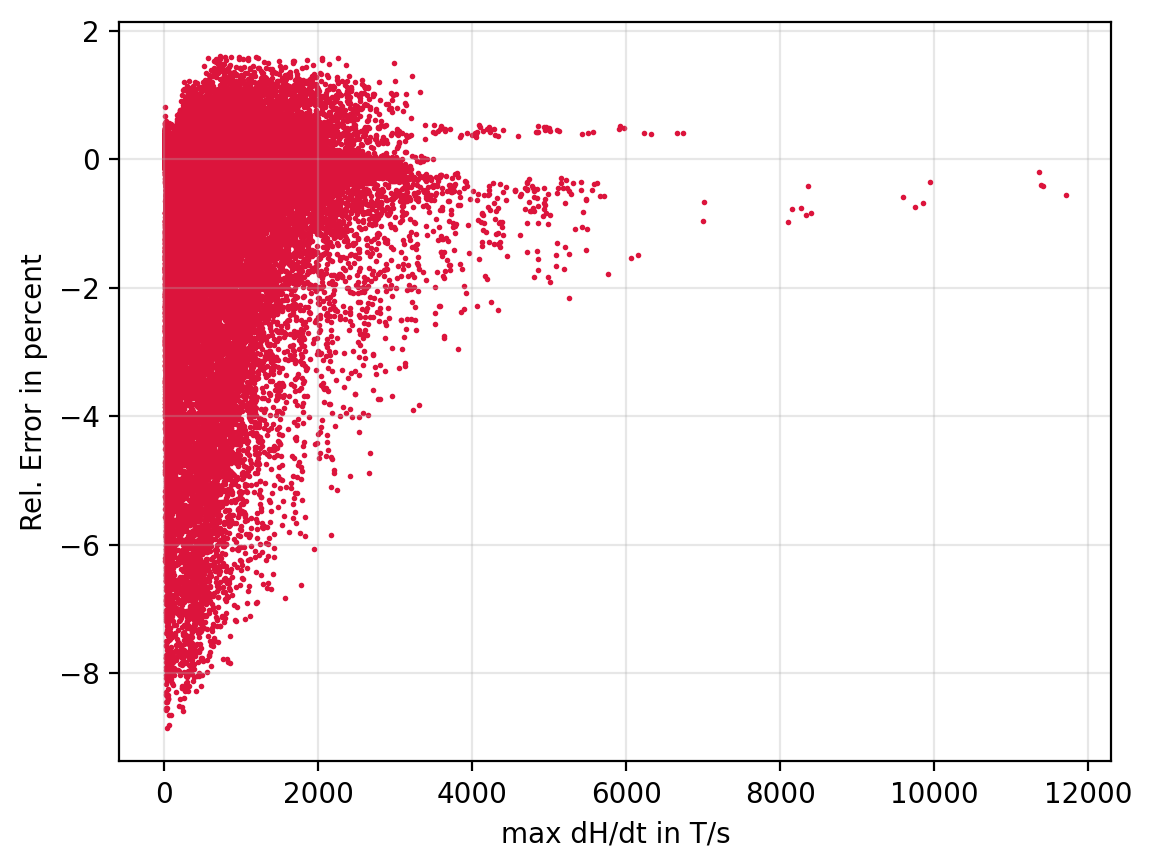

In [6]:
plt.figure(dpi=200)
plt.scatter(np.abs(full_h[:, 1:] - full_h[:, :-1]).max(axis=1)*ds.freq/1024, ds.ploss_rel_error*100, s=1.0, color='crimson')
plt.xlabel("max dH/dt in T/s")
plt.ylabel("Rel. Error in percent")

## Visualize Relative Error Ploss vs. Integral B-H

In [3]:
ds["computed_bh_area"] = get_bh_integral(ds)
ds.loc[:, ['ploss', 'computed_bh_area']]

ploss  computed_bh_area
0       2.427750e+03      2.430800e+03
1       3.332726e+03      3.329730e+03
2       4.502908e+03      4.509890e+03
3       6.063023e+03      6.076032e+03
4       8.043414e+03      8.057609e+03
...              ...               ...
204519  2.027170e+06      2.006894e+06
204520  1.475592e+05      1.408163e+05
204521  6.294548e+04      6.052808e+04
204522  1.134253e+05      1.098437e+05
204523  4.202796e+05      4.125891e+05

[204524 rows x 2 columns]

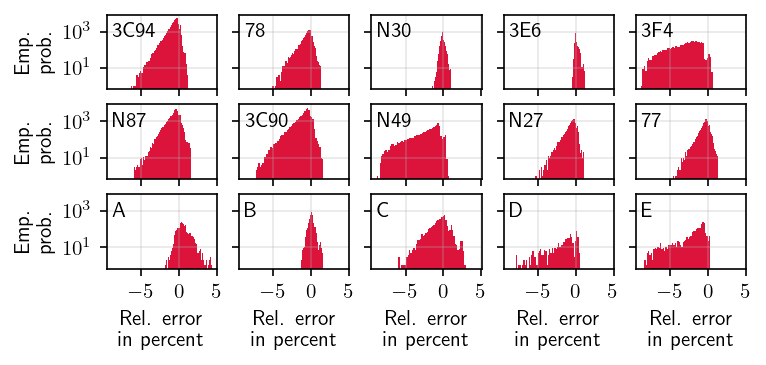

In [4]:
import matplotlib as mpl

plt.style.use("default")
with mpl.rc_context(
    {
        "text.usetex": True,  # requires "sudo apt install cm-super dvipng" on linux
        #"text.latex.preamble": r"\usepackage[vvarbb]{newtx}",
        "font.family": "serif",
        "font.serif": ["Helvetica"],
        "figure.dpi": 200,  # renders images larger for notebook
        "axes.grid": True,
        "grid.alpha": 0.3,
        "axes.titlesize": 10,
    }
):
    fig, axes = plt.subplots(3, 5, sharex=True, sharey=True, dpi=150, figsize=(5.5, 2.2))
    # plt.figure(dpi=200)

    for ax, (mat_lbl, mat_df) in zip(
        axes.flatten(), ds.groupby("material", sort=False)
    ):
        calc_error = (mat_df.computed_bh_area - mat_df.ploss) / mat_df.ploss
        ax.hist(calc_error * 100, color="crimson", bins=50, log=True)
        ax.text(0.05, 0.7, s=mat_lbl, transform=ax.transAxes)
        if ax in axes[:, 0]:
            ax.set_ylabel("Emp.\nprob.")
        if ax in axes[-1, :]:
            ax.set_xlabel("Rel. error\nin percent")
        # ax.set_xlim(-5, 3)
        # ax.set_ylim(1, None)
    # fig.tight_layout()

    fig.savefig(IMG_PATH / "area_vs_p_error.pdf", dpi=300, bbox_inches="tight")

In [12]:

fig, axes = plt.subplots(3, 5, sharex=True, sharey=True, dpi=150, figsize=(5.5, 2.2))
# plt.figure(dpi=200)

for ax, (mat_lbl, mat_df) in zip(
    axes.flatten(), ds.groupby("material", sort=False)
):
    trapz_loss =  mat_df.freq * np.trapz(mat_df.loc[:, ALL_H_COLS].to_numpy(), mat_df.loc[:, ALL_B_COLS].to_numpy(), axis=1)
    calc_error = (trapz_loss - mat_df.ploss) / mat_df.ploss
    ax.hist(calc_error * 100, color="crimson", bins=50, log=True)
    ax.text(0.05, 0.7, s=mat_lbl, transform=ax.transAxes)
    if ax in axes[:, 0]:
        ax.set_ylabel("Emp.\nprob.")
    if ax in axes[-1, :]:
        ax.set_xlabel("\nRel. error\nin percent")
    # ax.set_xlim(-5, 3)
    # ax.set_ylim(1, None)
    # fig.tight_layout()

fig.savefig(IMG_PATH / "area_vs_p_error_trapz.pdf", dpi=300, bbox_inches="tight")

Text(0, 0.5, 'Relative error in percent')

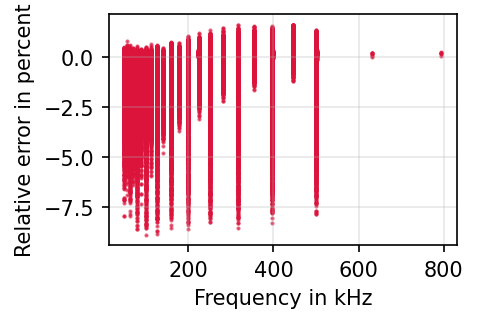

In [123]:
plt.figure(dpi=150, figsize=(3, 2))
plt.scatter(ds.freq*1e-3, ( ds.computed_bh_area - ds.ploss) / ds.ploss*100, color='crimson', s=1, alpha=0.6)
plt.xlabel("Frequency in kHz")
plt.ylabel("Relative error in percent")

Text(0, 0.5, 'Relative error in percent')

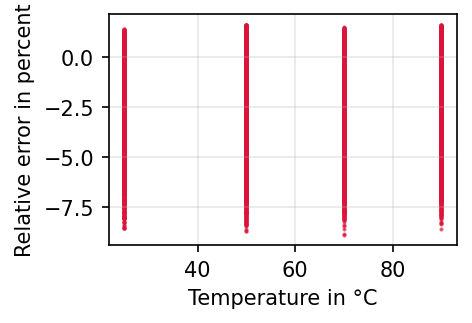

In [122]:
plt.figure(dpi=150, figsize=(3, 2))
plt.scatter(ds.temp, ( ds.computed_bh_area - ds.ploss)/ ds.ploss*100, color='crimson', s=1, alpha=0.6)
plt.xlabel("Temperature in °C")
plt.ylabel("Relative error in percent")

## How hard is predicting the initial/terminal H value?
As a pre analysis for differential equation based methods

Text(0.5, 1.0, 'Initial value scatter')

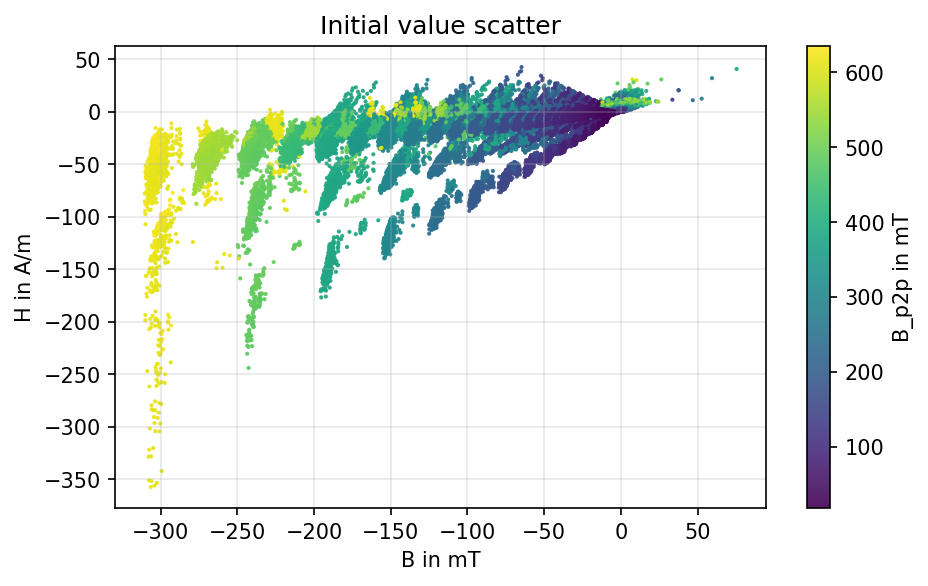

In [8]:
# initial values
plt.figure(dpi=150, figsize=(7,4))
plt.scatter(full_b[:, 0]*1000, full_h[:, 0], s=1.0, alpha=0.9, c=1000*(full_b.max(axis=1) - full_b.min(axis=1)), cmap='viridis')
cb = plt.colorbar()
cb.set_label('B_p2p in mT')
plt.xlabel('B in mT')
plt.ylabel("H in A/m")
plt.title('Initial value scatter')

Text(0.5, 1.0, 'Initial value scatter')

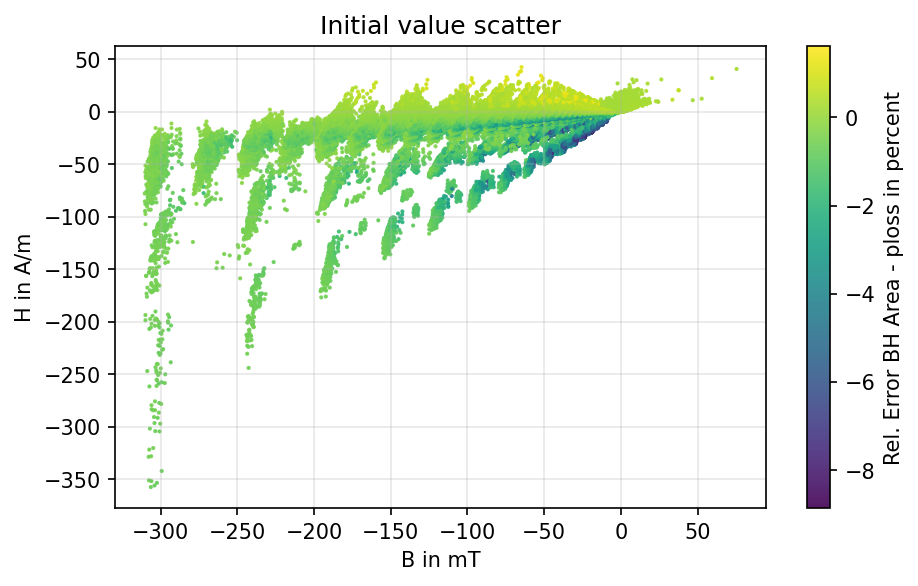

In [9]:
# initial values
plt.figure(dpi=150, figsize=(7,4))
plt.scatter(full_b[:, 0]*1000, full_h[:, 0], s=1.0, alpha=0.9, c=(ds.computed_bh_area - ds.ploss) / ds.ploss*100, cmap='viridis')
cb = plt.colorbar()
cb.set_label('Rel. Error BH Area - ploss in percent')
plt.xlabel('B in mT')
plt.ylabel("H in A/m")
plt.title('Initial value scatter')

no strong patterns are evident for the initial H value given the initial B with respect to peak2peak B value in the period or the relative error of the approximation of the power loss through the BH polygon area.

Text(0.5, 1.0, 'Terminal value scatter')

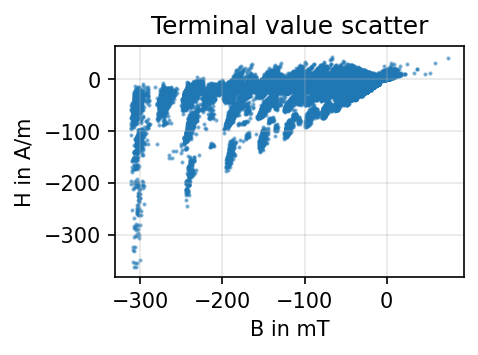

In [8]:
# terminal values
plt.figure(dpi=150, figsize=(3,2))
plt.scatter(full_b[:, -1]*1000, full_h[:, -1], s=1.0, alpha=0.5)
plt.xlabel('B in mT')
plt.ylabel("H in A/m")
plt.title('Terminal value scatter')

terminal values seem to be close to initial values. Check below

Text(0, 0.5, 'Empirical Probability')

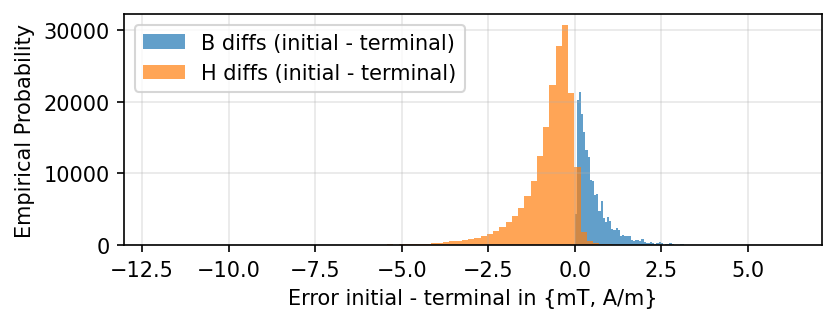

In [25]:
# is the initial value always the terminal value?
plt.figure(dpi=150, figsize=(6,2))
plt.hist(1000*(full_b[:, 0] - full_b[:, -1]), label='B diffs (initial - terminal)', bins=100, alpha=0.7)
plt.hist(full_h[:, 0] - full_h[:, -1], label='H diffs (initial - terminal)', bins=100, alpha=0.7)
plt.legend()
plt.xlabel("Error initial - terminal in {mT, A/m}")
plt.ylabel("Empirical Probability")

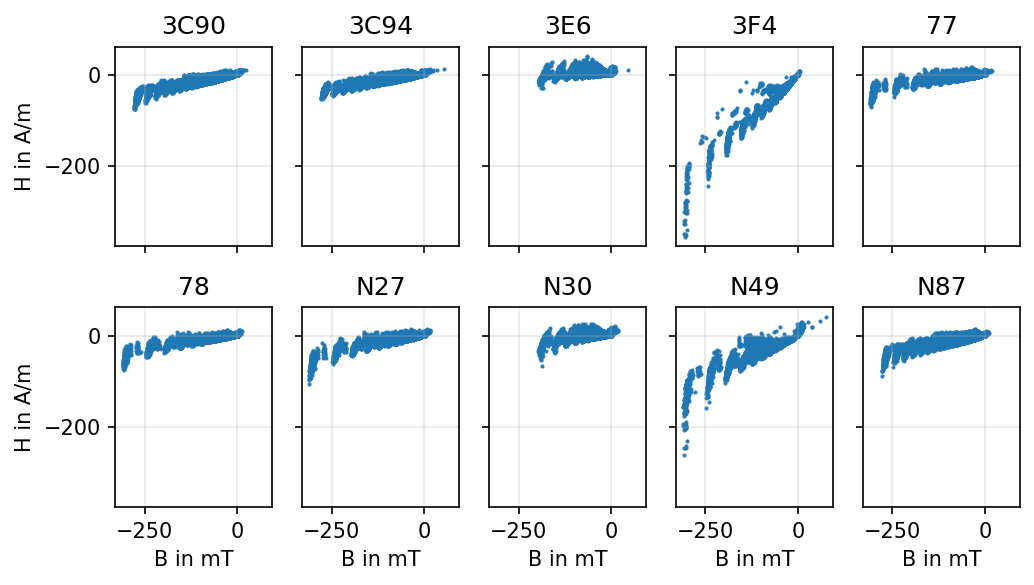

In [28]:
# max H over power loss
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    h = mat_df.loc[:, f"H_t_0"].to_numpy()
    b = 1000*mat_df.loc[:, f"B_t_0"].to_numpy()
    ax.scatter(b, h, alpha=.9, s=1.0)
    
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("H in A/m")
axes[1, 0].set_ylabel("H in A/m")
for ax in axes[-1, :]:
    ax.set_xlabel("B in mT")
fig.tight_layout()

Text(0.5, 1.0, 'Initial value scatter per material')

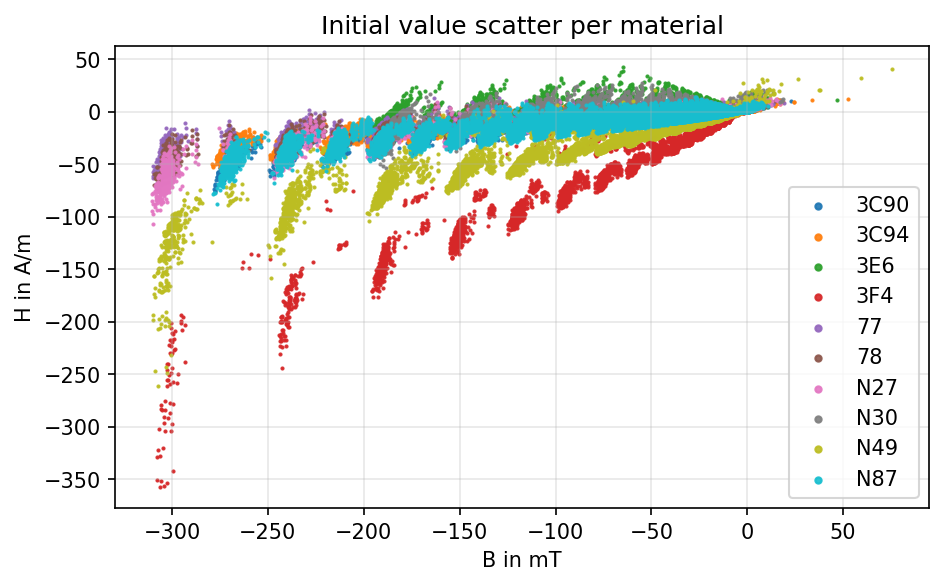

In [14]:
# initial values
plt.figure(dpi=150, figsize=(7,4))
for mat_name, mat_df in ds.groupby("material"):
    b, h = mat_df.loc[:, [f"B_t_0"]].to_numpy(), mat_df.loc[:, [f"H_t_0"]].to_numpy()
    plt.scatter(b*1000, h, s=1.0, alpha=0.9, label=mat_name)
plt.legend(markerscale=3)
plt.xlabel('B in mT')
plt.ylabel("H in A/m")
plt.title('Initial value scatter per material')

Text(0.5, 1.0, 'Initial value scatter per waveform')

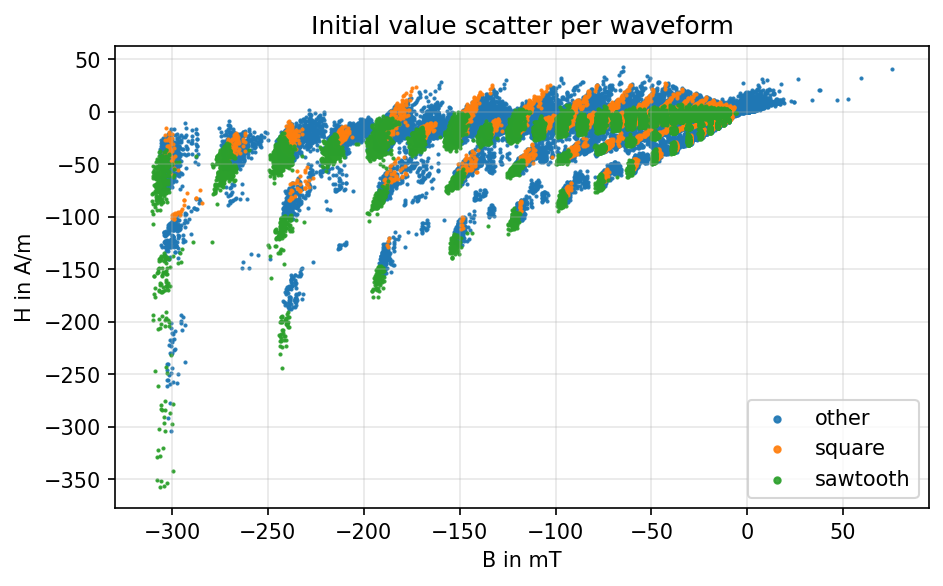

In [37]:
# initial values per signal waveform
plt.figure(dpi=150, figsize=(7,4))
for wav, mat_df in ds.groupby("waveform"):
    b, h = mat_df.loc[:, [f"B_t_0"]].to_numpy(), mat_df.loc[:, [f"H_t_0"]].to_numpy()
    plt.scatter(b*1000, h, s=1.0, alpha=0.9, label=template_lbls[wav])
plt.legend(markerscale=3)
plt.xlabel('B in mT')
plt.ylabel("H in A/m")
plt.title('Initial value scatter per waveform')

In [16]:
# analyze specific blobs
op1 = ds.query("material == '3F4' and -0.250 < B_t_0 < -0.200 and -250 < H_t_0 < 100")
op2 = ds.query("material == '3F4' and -0.200 < B_t_0 < -0.170 and -200 < H_t_0 < 100")

Text(0.5, 1.0, 'Initial value scatter for two blobs')

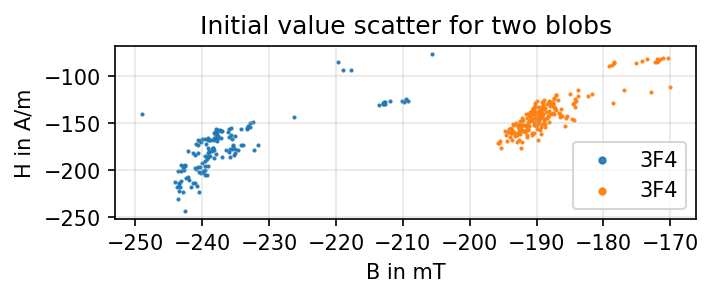

In [38]:
# initial values
plt.figure(dpi=150, figsize=(5,1.5))
b, h = op1.loc[:, [f"B_t_0"]].to_numpy(), op1.loc[:, [f"H_t_0"]].to_numpy()
plt.scatter(b*1000, h, s=1.0, alpha=0.9, label=op1.material.unique()[0])
b, h = op2.loc[:, [f"B_t_0"]].to_numpy(), op2.loc[:, [f"H_t_0"]].to_numpy()
plt.scatter(b*1000, h, s=1.0, alpha=0.9, label=op2.material.unique()[0])
plt.legend(markerscale=3)
plt.xlabel('B in mT')
plt.ylabel("H in A/m")
plt.title('Initial value scatter for two blobs')

Text(0.5, 1.0, 'Initial value scatter for two blobs')

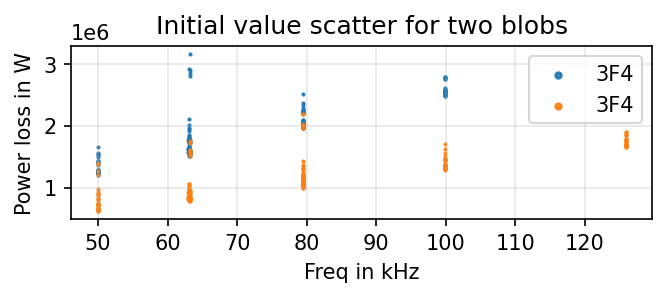

In [39]:
# initial values of 2 ops over freq
plt.figure(dpi=150, figsize=(5,1.5))
freq, h = op1.loc[:, "freq"].to_numpy(), op1.loc[:, "ploss"].to_numpy()
plt.scatter(freq/1000, h, s=1.0, alpha=0.9, label=op1.material.unique()[0])
freq, h = op2.loc[:, "freq"].to_numpy(), op2.loc[:, "ploss"].to_numpy()
plt.scatter(freq/1000, h, s=1.0, alpha=0.9, label=op2.material.unique()[0])
plt.legend(markerscale=3)
plt.xlabel('Freq in kHz')
plt.ylabel("Power loss in W")
plt.title('Initial value scatter for two blobs')

Text(0.5, 1.0, 'Initial value scatter for two blobs')

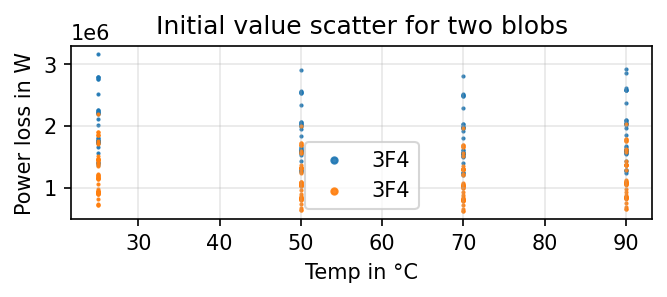

In [40]:
# initial values of 2 ops over temp
plt.figure(dpi=150, figsize=(5,1.5))
te, h = op1.loc[:, "temp"].to_numpy(), op1.loc[:, "ploss"].to_numpy()
plt.scatter(te, h, s=1.0, alpha=0.9, label=op1.material.unique()[0])
te, h = op2.loc[:, "temp"].to_numpy(), op2.loc[:, "ploss"].to_numpy()
plt.scatter(te, h, s=1.0, alpha=0.9, label=op2.material.unique()[0])
plt.legend(markerscale=3)
plt.xlabel('Temp in °C')
plt.ylabel("Power loss in W")
plt.title('Initial value scatter for two blobs')

it is still open how these blobs appear

# How hard is predicting the h value for B-max?

In [53]:
np.argmax(full_b, axis=1).shape

(186747,)

Text(0.5, 1.0, 'Bmax to H value scatter')

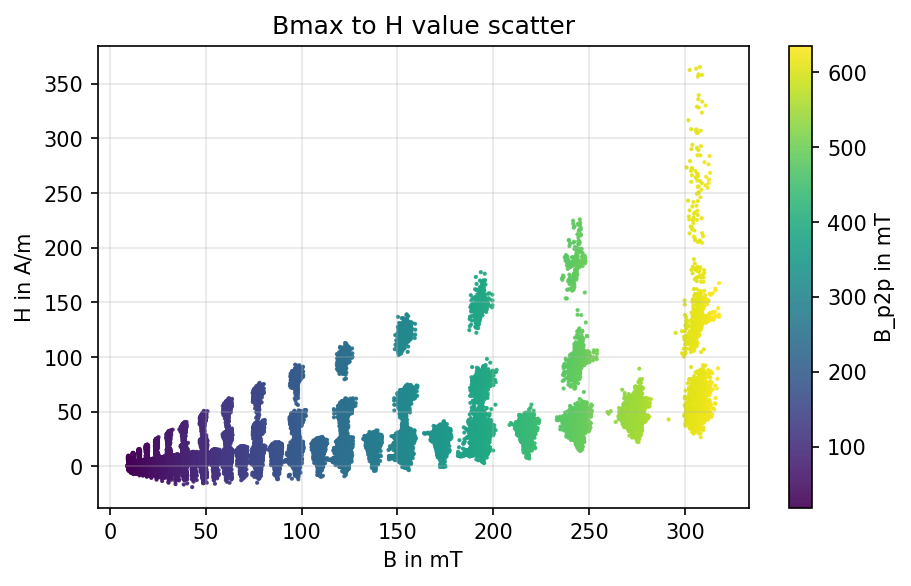

In [55]:
# initial values
plt.figure(dpi=150, figsize=(7,4))
x = full_b.max(axis=1)*1000
y = full_h[np.arange(len(full_h)), np.argmax(full_b, axis=1)]
plt.scatter(x, y, s=1.0, alpha=0.9, c=1000*(full_b.max(axis=1) - full_b.min(axis=1)), cmap='viridis')
cb = plt.colorbar()
cb.set_label('B_p2p in mT')
plt.xlabel('B in mT')
plt.ylabel("H in A/m")
plt.title('Bmax to H value scatter')

first of june 2023 - discussion

possible equations to base on:
- Erika Stenglein (eq. based on pre-states, regression model to power losses)
- Maxwell doesnt give hints on how to obtain H from B
- differential equation would be preferrable (still open)
-- probably existing in material literature (molecular level)
- promising feature could be the deviation from a perfect sinusoidal waveform
- Check whether the phase difference between B and H increases for higher B-peak2peak


# Checks for mag-net-hub
as of 19th march 2024

In [10]:
ds.query("ploss < 451e3 and ploss > 450e3").groupby('material').agg('size')

material
3C90    16
3C94    10
3E6      3
3F4      1
77       3
78       2
A        2
B        5
C        2
E        2
N27      1
N30      4
N87     12
dtype: int64

In [2]:
from utils.data import load_material_csv_files_and_generate_pandas_df

MATERIALS = [
    "ML95S",
    "T37",
    "3C90",
    "3C92",
    "3C94",
    "3C95",
    "3E6",
    "3F4",
    "77",
    "78",
    "79",
    "N27",
    "N30",
    "N49",
    "N87",
]
df_mats_l = []
raw_path = Path().cwd().parent / 'data' / 'input' /'raw'
for mat in MATERIALS:
    
    df_l = []
    for mat_folder in raw_path.glob(f"**/{mat}"):
        print(f"found mat folder: {mat_folder}")
        df_l.append(load_material_csv_files_and_generate_pandas_df(mat_folder, material=mat))
    if len(df_l) == 0:
        raise ValueError(f"Found no material folder for {mat=} in {raw_path}")
    ds = pd.concat(df_l, ignore_index=True)
    # DEBUG
    #df_mats_l.append(ds.query("ploss < 451e3 and ploss > 450e3").drop(columns=[c for c in ds if c.startswith("H_t")]))
    df_mats_l.append(ds.drop(columns=[c for c in ds if c.startswith("H_t")]))
#pd.concat(df_mats_l, ignore_index=True).to_csv(f'unit_test_data_ploss_at_450kWpm3.csv', index=False)
pd.concat(df_mats_l, ignore_index=True).to_csv(f"all_data.csv.gzip", index=False)

found mat folder: /home/wk/dev/projects/hardcore-magnet-challenge/Model/data/input/raw/final-training/ML95S
found mat folder: /home/wk/dev/projects/hardcore-magnet-challenge/Model/data/input/raw/final-testing/ML95S
found mat folder: /home/wk/dev/projects/hardcore-magnet-challenge/Model/data/input/raw/final-training/T37
found mat folder: /home/wk/dev/projects/hardcore-magnet-challenge/Model/data/input/raw/final-testing/T37
found mat folder: /home/wk/dev/projects/hardcore-magnet-challenge/Model/data/input/raw/pre-testing/3C90
found mat folder: /home/wk/dev/projects/hardcore-magnet-challenge/Model/data/input/raw/pre-training/3C90
found mat folder: /home/wk/dev/projects/hardcore-magnet-challenge/Model/data/input/raw/final-training/3C92
found mat folder: /home/wk/dev/projects/hardcore-magnet-challenge/Model/data/input/raw/final-testing/3C92
found mat folder: /home/wk/dev/projects/hardcore-magnet-challenge/Model/data/input/raw/pre-testing/3C94
found mat folder: /home/wk/dev/projects/hardcore

In [4]:
for m, df in zip(MATERIALS, df_mats_l):
    print(m, len(df))

ML95S 5749
T37 10570
3C90 45711
3C92 10081
3C94 45066
3C95 10712
3E6 11994
3F4 11562
77 16442
78 16378
79 7877
N27 16394
N30 13976
N49 13600
N87 45614
